# <b>Classification of Covid Infection Based on Chest X-Ray Images</b>
### <b>Table of Contents</b> <a id="table-contents"></a>
This is the milestone 4 of the CS109B class during Spring 2024 with members Xinyu Chen, Adele Collin, Chuck Lin, Kay Wu (Group #22). 

*Note that the internal links of the table of contents work in Jupyter notebook, but VSCode and Google Colab may have compatibility issues.*
1. [Problem Statement](#problem_statement)
2. [Data Preprocessing](#data_preprocessing)
3. [EDA (exploratory data analysis)](#eda)
4. [Baseline Model Selection, Justification, With Results Interpretation And Analysis](#baseline_model)
5. [Final Model Pipeline Setup](#final_model)
6. [TF Meeting](#tf_meeting)

<a id="problem_statement"></a>
# 1. Problem Statement

<div style="background: #f5f5dc; border: thin solid black; padding: 5px">

The Covid-19 pandemic from 2019 to 2023 caused massive health burdens and death, public health and government expenditures, and severe market loss and societal fluctuations. In fact, within 2024 where Covid-19 has officially been announced to end, according to CDC there were still 7 million hospitalizations due to Covid to date ([accessed April 2024 from CDC](https://covid.cdc.gov/covid-data-tracker/#datatracker-home)). Within the health system, the vast number of population impacted by the virus overloaded the hospistals. The challenges presented by Covid include but are not limited to the shortage in medical supplies and resource allocation depending on condition severity and overwhelmed medical staff. Overall the resources were limited for the patients impacted and often caused delay in treatment with consequences that could have been avoided. A machine learning model that is able to preliminarily screen chest x-rays for patients for identification of Covid infections would be beneficial for addressing the problem (eg. for early detection, treatment, supportive care, and implementation of public health policies), and here we propose to test the performance of such a model. 

Based on the EDA, we have discovered certain features of the datasets, such as the relatively stable image quality across datasets, different labels and dataset distribution shifts, and undocumented underlying concurrent conditions within the data. This makes the dataset noisy and presents a challenge for training the machine learning model. Our problem question is as follows: can signs of Covid-19 in x-ray scans be identified using machine learning approaches, to predict whether a patient has covid or not, with noisy image sets (e.g. patients have none or a variety of concurrent conditions other than covid, image rotation, position of patient taking the x ray, e.t.c.)? And how robust will this prediction be to different clinical settings? 

<a id="eda"></a>
# 2. EDA (exploratory data analysis)

<div style="background: #f5f5dc; border: thin solid black; padding: 5px">

Below we show the original exploratory data analysis for three datasets used in this project, consisting of the Brixia dataset for positive training samples, the NIHCXR for negative training samples, and COVIDGR for validation with balanced positive and negative samples. 

The first dataset, the Brixia Score Covid19 Dataset, curated by ASST Spedali Civili di Brescia, comprises 4,707 chest X-ray (CXR) images obtained from sub-intensive and intensive care units over a specific period from March 4th to April 4th, 2020, notably coinciding with the peak of the COVID-19 pandemic. Brixia was acquired through both computed radiography (CR) and digital radiography (DX) modalities, encompassing both anterior-posterior (AP) and posterior-anterior (PA) projections.

The second dataset, the NIH Chest X-ray Dataset, consists of 112,120 frontal-view X-ray images extracted from 30,805 individual patients, and annotated with fourteen distinct thoracic pathologies derived from radiological reports. This dataset contained covid negative samples but also indicated other concurrent conditions, which this information were not contained in the other two datasets.

Lastly, the COVIDGR-1.0 dataset, developed through collaboration with specialists from Hospital Universitario San Cecilio, Spain, comprises of 852 anonymized CXR images categorized into positive and negative instances based on the results of COVID-19 tests conducted via reverse transcription-polymerase chain reaction (RT-PCR) within 24 hours of image acquisition. Consistently captured in the posterior-anterior aspect, these images are classified according to severity levels and accompanied by demographic attributes, including gender distributions, for each identifiable class.

The three datasets combined add up to over 100GB of data, and while we are still performing data compression, we sampled a subset of the two training datasets for preliminary data analysis and model training. For the original EDA from the last milestone we performed the image intensity and pixel intensity calcualtion to examine the quality of the images, and found the image quality to be relatively consistent across the datasets. To define these terms, pixel intensity refers to the brightness or grayscale value of an individual pixel in a digital image. Image intensity, on the other hand, refers to the overall brightness or grayscale value of an entire image. It represents the collective pixel intensities across all pixels in the image. By sampling a few images with the highest and lowest image intensity we identified some room for improvements for preprocessing. By resizing and squaring the images to 224x224, some smaller images got padded with 0, some narrower images got compressed or rotated. Additionally, the graphical labelling such as the letters indicating position of the patient when the x-ray was taken, varies in the datasets. This indicates the noisiness of the data and we will address it with further preprocessing, distribution shift, and by utilizing transfer learning models to indirectly improve the performance of the model on nonhomogeneous datasets. We also looked at the bias in demographics. The validation set didn't have any demographics information provided, but for the two training sets, both have the mean age distribution centered around 60 years old and have more male patients, which may present bias in the model and prevent generalization.

In [ ]:
################################################################################
# IMPORT LIBRARIES
################################################################################
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import random
import skimage
from skimage.transform import resize
from pathlib import Path
from scipy.ndimage import gaussian_filter

import tensorflow as tf
from tensorflow.keras.layers import Input, GaussianNoise, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad, Adadelta, Adamax

In [9]:
################################################################################
# LOAD THE DATA
################################################################################
##For local loading:
root = str(os.path.dirname(os.path.realpath('baseline_models.ipynb')))
root = root[1:] + '/'

br_path = '/' +os.path.join(root, "Data/Brixia/Brixia images size 224 arrays.npy")
df_brixia = np.load(br_path)

nih_path = '/' + os.path.join(root,"Data/NIHCXR/image1/NIHCXR images size 224 arrays.npy")
df_nihcxr = np.load(nih_path)

co_path_1 = '/' + os.path.join(root,"Data/COVIDGR_1.0/COVID Positive Array 224.npy")
co_path_2 = '/' + os.path.join(root,"Data/COVIDGR_1.0/COVID Negative Array 224.npy")
df_covidgr_positive = np.load(co_path_1)
df_covidgr_negative = np.load(co_path_2)


##For cloud loading:
#df_brixia = np.load("Data/Brixia/Brixia images size 224 arrays.npy")
#df_nihcxr = np.load("Data/NIHCXR/NIHCXR images size 224 arrays.npy")
#df_covidgr_positive = np.load("Data/COVIDGR_1.0/COVID Positive Array 224.npy")
#df_covidgr_negative = np.load("Data/COVIDGR_1.0/COVID Negative Array 224.npy")

In [ ]:
################################################################################
# PROCESS THE DATA
################################################################################
#Training and Validation data
X_train = np.vstack((df_brixia, df_nihcxr))
y_train = np.concatenate((np.ones(df_brixia.shape[0]), np.zeros(df_nihcxr.shape[0])))

X_test = np.vstack((df_covidgr_positive, df_covidgr_negative))
y_test = np.concatenate((np.ones(df_covidgr_positive.shape[0]), np.zeros(df_covidgr_negative.shape[0])))

In [2]:
################################################################################
# HELPER: BASIC
################################################################################
def sample_dim_type(data_name, df):
    print(f"======================{data_name}==========================")
    print(f"\t number of samples in {data_name}: ", df.shape[0])
    # Image dimension 
    print("\t image dimension (height, width, channel): ", df.shape[1:])
    # Image data type
    print("\t image data type: ", df.dtype)

In [11]:
################################################################################
# HELPER: IMAGE INTENSITY
################################################################################
def image_intensity(data_name, df):
    # Average image intensity (compare between samples)
    print(f"======================{data_name}==========================")
    print("\t average image intensity: ", np.mean(np.mean(df, axis=(1,2,3)))) #== np.mean(df_train)
    # Maximum image intensity 
    max_intensity= np.max(np.mean(df, axis=(1,2,3)))
    print("\t maximum image intensity: ", max_intensity)
    # Minimum image intensity
    min_intensity = np.min(np.mean(df, axis=(1,2,3)))
    print("\t minimum image intensity: ", min_intensity)
    ## Stadard deviation of image intensity
    print("\t standard of image intensity: ", np.std(np.mean(df, axis=(1,2,3))))

    # Visualize the max and min intensity images -- can we see any visual difference?
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs = axs.flatten()
    axs[0].imshow(df[np.argmax(np.mean(df, axis=(1,2,3))), :, :,:], cmap='gray')
    axs[0].set_title("image with maximum image intensity")
    axs[1].imshow(df[np.argmin(np.mean(df, axis=(1,2,3))), :, :,:], cmap='gray')
    axs[1].set_title("image with minimum image intensity")

    # Create a histogram of the pixel intensity
    plt.figure(figsize=(10, 5))
    plt.hist(df.ravel(), bins=256, color='blue', alpha=0.4)
    #plt.legend(loc='upper right')
    plt.xlabel('Intensity Value')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Pixel Intensity in {data_name}')
    plt.show()

    # Create a histogram of the image intensity
    plt.figure(figsize=(10, 5))
    plt.hist(np.mean(df, axis=(1,2,3)), bins=256, color='blue', alpha=0.4)
    #plt.legend(loc='upper right')
    plt.xlabel('Intensity Value')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Image Intensity in {data_name}')
    plt.show()
    print(f"with min intensity of {min_intensity} and max intensity of {max_intensity}, \n there are no outliers in this dataset")

======================brixia==========================
	 number of samples in brixia:  469
	 image dimension (height, width, channel):  (224, 224, 1)
	 image data type:  float32
======================brixia==========================
	 average image intensity:  0.53036904
	 maximum image intensity:  0.69281775
	 minimum image intensity:  0.28426707
	 standard of image intensity:  0.07222104


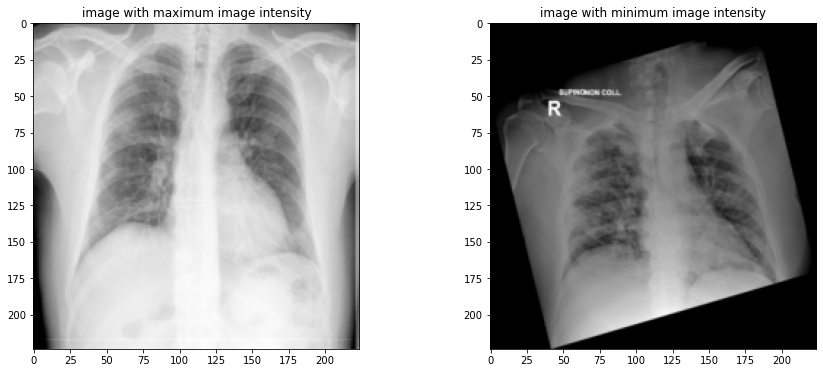

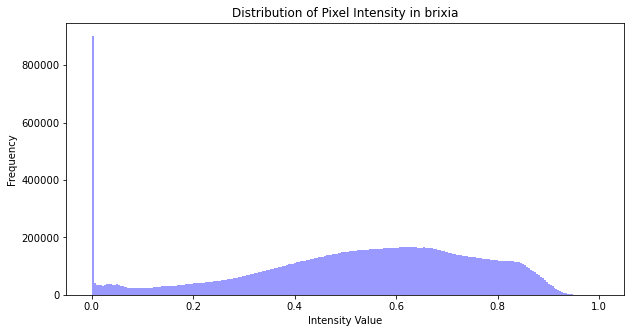

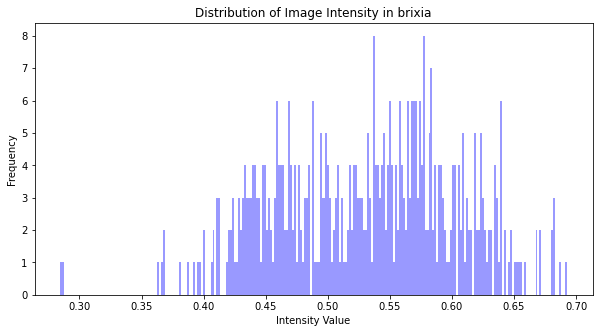

with min intensity of 0.2842670679092407 and max intensity of 0.692817747592926, 
 there are no outliers in this dataset
                               min         max          mean           std
StudyDate               20200304.0  20200409.0  2.020033e+07     32.166845
Columns                     2019.0      3376.0  2.893871e+03    152.103555
Rows                        1056.0      3050.0  2.405939e+03    142.821628
BrixiaScore                    0.0    333333.0  1.021193e+05  99594.274301
BrixiaScoreGlobal              0.0        18.0  8.301171e+00      4.238625
ConsensusTestset               0.0         1.0  3.194888e-02      0.175883
AgeAtStudyDateFiveYear         1.0        19.0  1.247668e+01      2.723331


Text(0.5, 1.0, 'distribution of photometric interpretation in the dataset')

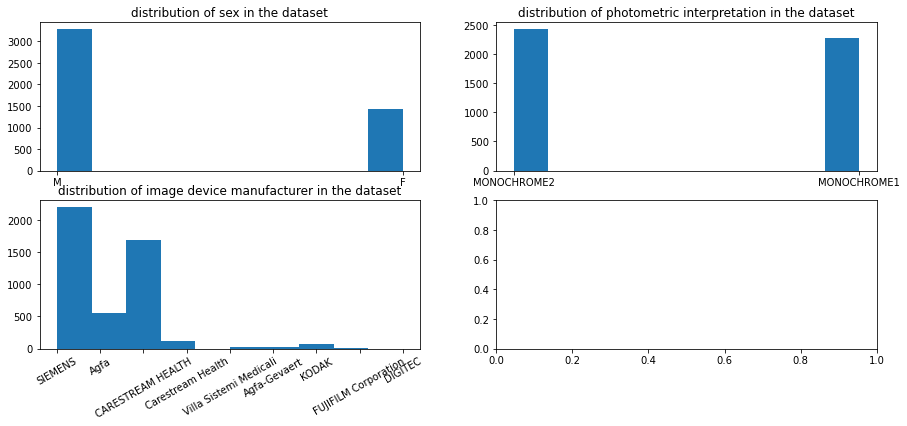

In [26]:
################################################################################
# BRIXIA (positive training)
################################################################################
#run helper functions
sample_dim_type("brixia", df_brixia)
image_intensity("brixia", df_brixia)

## relationship between variables, meta data
#numerical data
metadata_path = '/' + os.path.join(root,"Data/Brixia/Brixia_metadata_global_v2.csv")
df_metadata = pd.read_csv(metadata_path, delimiter=";")
print(df_metadata.describe().transpose()[["min", "max", "mean", "std"]])

#categorical data
fig, axs = plt.subplots(2, 2, figsize=(15, 6))
axs = axs.flatten()
axs[0].hist(df_metadata['Sex'])
axs[0].set_title("distribution of sex in the dataset")
axs[2].hist(df_metadata['Manufacturer'])
axs[2].tick_params(axis="x", rotation=30)
axs[2].set_title("distribution of image device manufacturer in the dataset")
axs[1].hist(df_metadata['PhotometricInterpretation'])
axs[1].set_title("distribution of photometric interpretation in the dataset")

======================nihcxr==========================
	 number of samples in nihcxr:  500
	 image dimension (height, width, channel):  (224, 224, 1)
	 image data type:  float32
======================nihcxr==========================
	 average image intensity:  0.5158608
	 maximum image intensity:  0.74893934
	 minimum image intensity:  0.3004221
	 standard of image intensity:  0.09409551


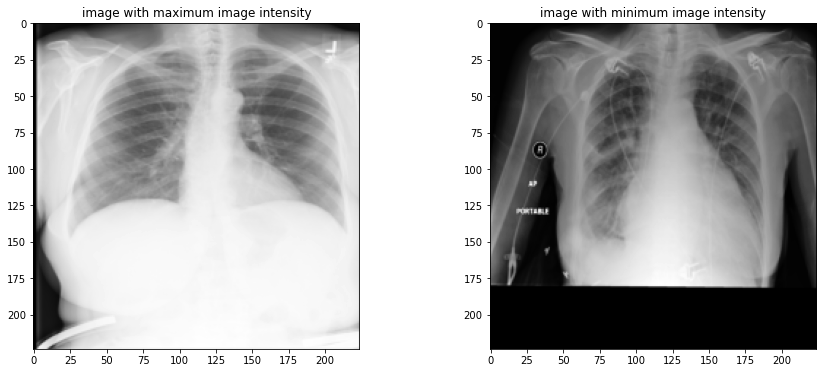

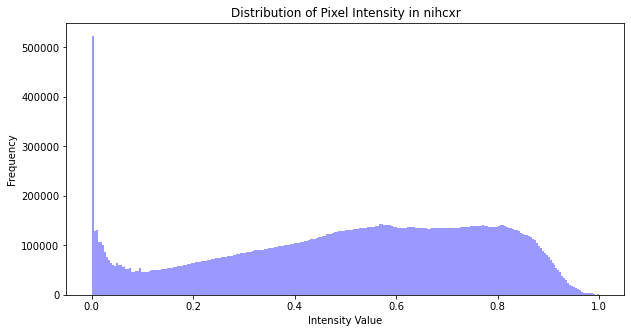

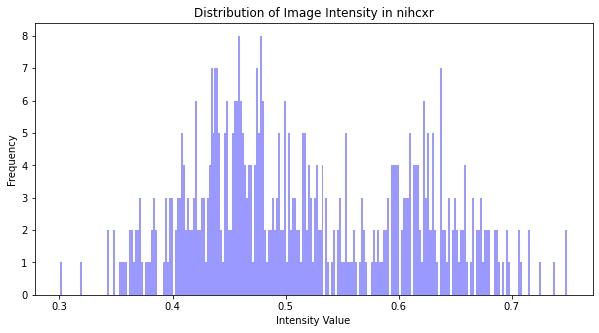

with min intensity of 0.3004221022129059 and max intensity of 0.7489393353462219, 
 there are no outliers in this dataset


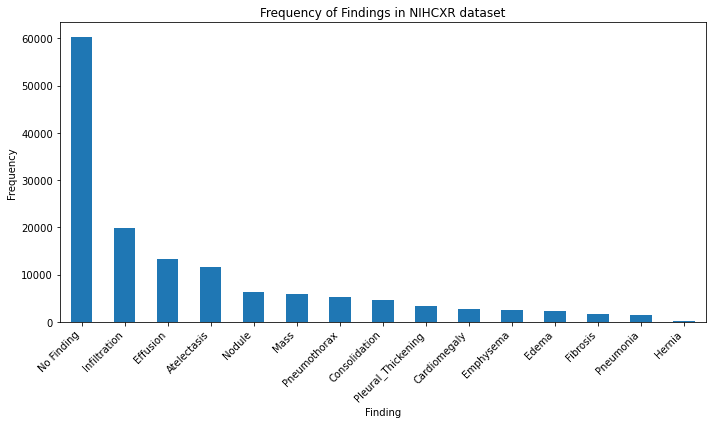

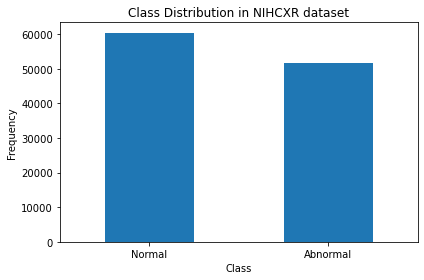

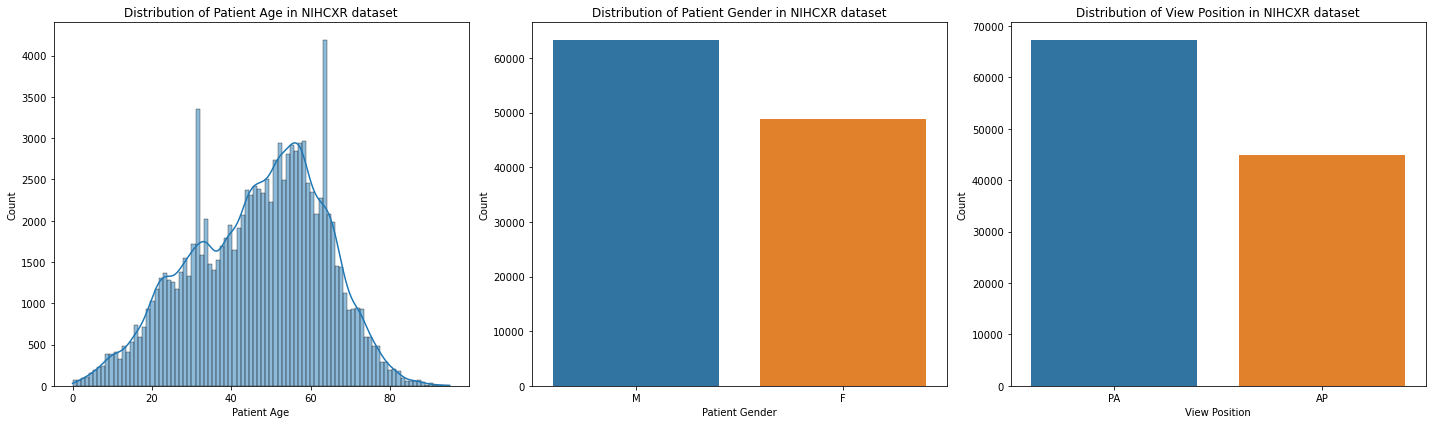

In [27]:
################################################################################
# NIHCXR (negative training)
################################################################################
#run helper functions
sample_dim_type("nihcxr", df_nihcxr)
image_intensity("nihcxr", df_nihcxr)

# Split values in the 'Finding Labels' column by '|'
csv_path = '/' + os.path.join(root, "Data/NIHCXR/Data_Entry_2017_v2020.csv")
df_labels = pd.read_csv(csv_path)
split_values = df_labels['Finding Labels'].str.split('|')

# Create a list to store all findings
all_findings = []

# Iterate over each row and add the findings to the list
for values in split_values:
    all_findings.extend(values)

# Count the occurrences of each finding
finding_counts = pd.Series(all_findings).value_counts()

# Plot the frequencies of each finding
plt.figure(figsize=(10, 6))
finding_counts.plot(kind='bar')
plt.title('Frequency of Findings in NIHCXR dataset')
plt.xlabel('Finding')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate the distribution of normal vs. abnormal cases
class_distribution = df_labels['Finding Labels'].apply(lambda x: 'Normal' if x == 'No Finding' else 'Abnormal').value_counts()

# Plot the class distribution
plt.figure(figsize=(6, 4))
class_distribution.plot(kind='bar')
plt.title('Class Distribution in NIHCXR dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


#demographic distribution (only exists in nihcxr, not the other two datasets)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# Create count plots or histograms for patient age, patient gender, and view position
sns.histplot(data=df_labels, x='Patient Age', ax=axes[0], kde=True)
axes[0].set_title('Distribution of Patient Age in NIHCXR dataset')
axes[0].set_xlabel('Patient Age')
axes[0].set_ylabel('Count')

sns.countplot(data=df_labels, x='Patient Gender', ax=axes[1])
axes[1].set_title('Distribution of Patient Gender in NIHCXR dataset')
axes[1].set_xlabel('Patient Gender')
axes[1].set_ylabel('Count')

sns.countplot(data=df_labels, x='View Position', ax=axes[2])
axes[2].set_title('Distribution of View Position in NIHCXR dataset')
axes[2].set_xlabel('View Position')
axes[2].set_ylabel('Count')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

======================covidgr-negative==========================
	 number of samples in covidgr-negative:  426
	 image dimension (height, width, channel):  (224, 224, 1)
	 image data type:  float32
======================covidgr-negative==========================
	 average image intensity:  0.52109724
	 maximum image intensity:  0.6609612
	 minimum image intensity:  0.20477296
	 standard of image intensity:  0.0507227


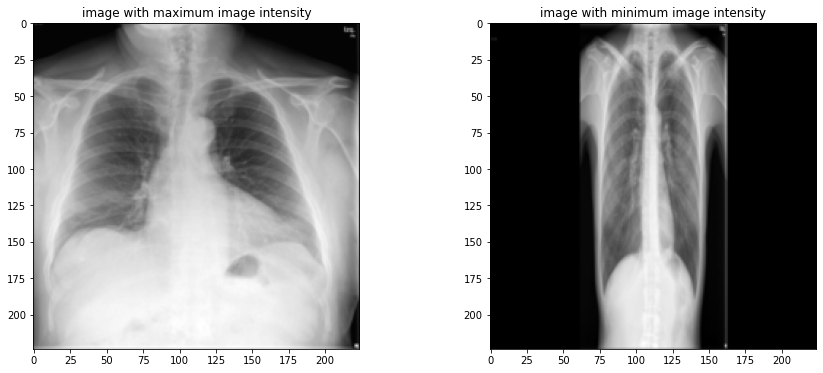

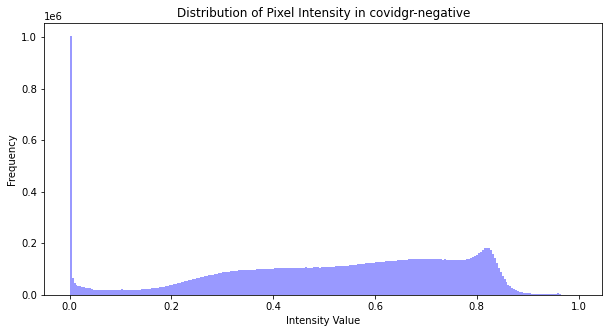

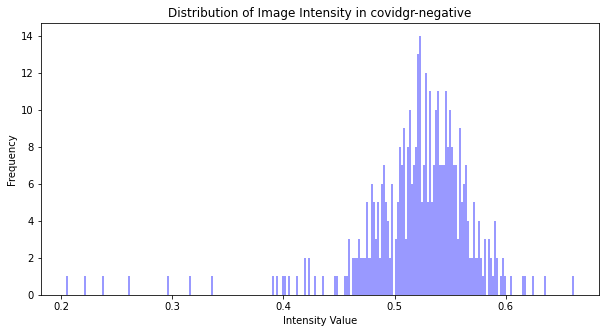

with min intensity of 0.2047729641199112 and max intensity of 0.6609612107276917, 
 there are no outliers in this dataset
======================covidgr-positive==========================
	 number of samples in covidgr-positive:  426
	 image dimension (height, width, channel):  (224, 224, 1)
	 image data type:  float32
======================covidgr-positive==========================
	 average image intensity:  0.53151315
	 maximum image intensity:  0.7555844
	 minimum image intensity:  0.26859397
	 standard of image intensity:  0.05474112


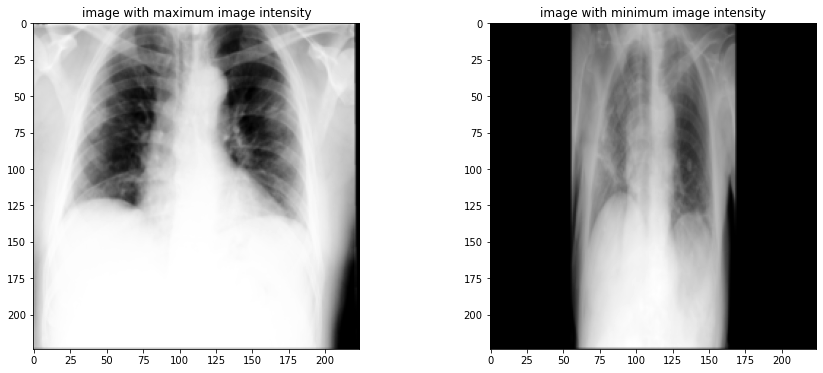

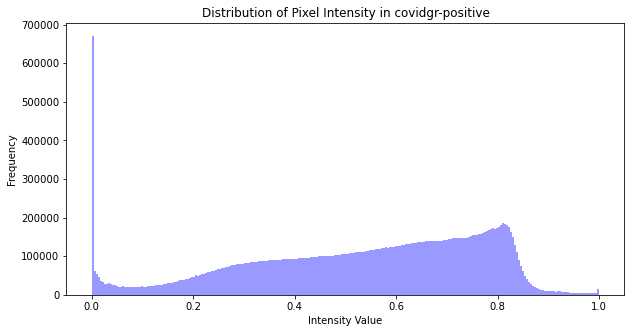

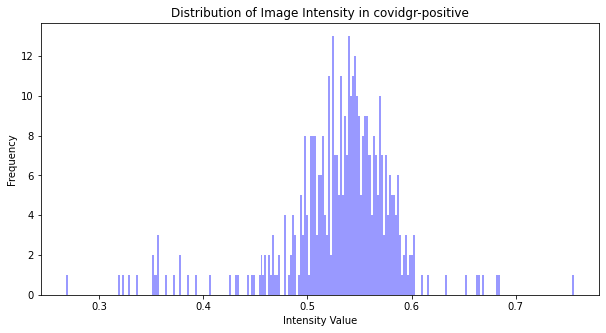

with min intensity of 0.268593966960907 and max intensity of 0.7555844187736511, 
 there are no outliers in this dataset


In [25]:
################################################################################
# COVIDGR (validation)
################################################################################

#run helper functions
sample_dim_type("covidgr-negative", df_covidgr_negative)
image_intensity("covidgr-negative", df_covidgr_negative)
sample_dim_type("covidgr-positive", df_covidgr_positive)
image_intensity("covidgr-positive", df_covidgr_positive)


<a id="data_preprocessing"></a>
# 3. Data Preprocessing

<div style="background: #f5f5dc; border: thin solid black; padding: 5px">

Based on the EDA from Milestone 3 and the TF feedback, we concluded that there were different distributions of the three datasets that we are using for training and testing our model. Furthermore, our original preprocessing approach resulted in some additional image padding and distortion because not all images were square. Thus, further preprocessing of the image data was necessary. We conducted a review of some of the literature on approaches used in chest x-ray classification for addressing distribution shifts. Broadly, common modelling approaches involve pre-training the model on a large, diverse image dataset and fine-tuning on data specific to a particular distribution, with the pre-training making the model robust to distribution shift (1). Studies that designed chest x-ray classifier models aimed at being generalizable have employed pixel value normalization to values between 0 and 1 (2) and resizing to 224 x 224 pixels (3). Other approaches include histogram equalization to extend the pixel’s intensity range from the original range to 0 to 255 such that the enhanced image has a wider range of intensity and slightly higher contrast, and adding Gaussian blur for noise reduction, which have been found to improve model performance (4). Still other approaches have used segmentation models such as U-net to segment and crop the lungs and convolutional neural networks for bone suppression for feature extraction and to enhance model performance despite distribution shifts (5).

Based on these insights and the EDA findings, we employed new image preprocessing approaches. Specifically, after selecting the images from the original files in the repository, we crop the image retaining the central region to make it square, resize it to 224 x 224 pixels to standardize and ensure uniformity in image dimensions, normalize the image intensity to a range of (0, 1) to reduce brightness level variation across different images, perform histogram equalization to enhance image contrast and make image contrast across datasets more consistent, and add Gaussian blur for denoising purposes, smoothing out the pixel intensity variations in the image. Finally, the images are converted to NumPy arrays to facilitate numerical operations and compatibility with machine learning algorithms. In summary, the feature engineering process aims to standardize and enhance the quality of chest x-ray images for subsequent analysis.

Visualizing the results of these preprocessing steps in the below figures and numbers, we can see that while not all issues with the padding have resolved (eg. some images were pre-rotated to address patient rotation but this resulted in padding at the corners), we were able to resolve the issues with image distortion and differences in pixel and image intensity distributions such that these are approximately similar/consistent across the different datasets. For next steps, once the entirety of the datasets have been uploaded, we will consider further steps to further balance the data in the image selection process such as balancing patient sex and selecting only chest x-rays with no findings in the NIHCXR (negative train) dataset for further alignment between datasets.

**References**
1. https://arxiv.org/pdf/2403.00194.pdf
2. https://www.nature.com/articles/s41598-024-56171-6
3. https://pubs.rsna.org/doi/epdf/10.1148/radiol.2020203511
4. https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0265949
5. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9818166/ 

In [ ]:
#root = str(os.path.dirname(os.path.realpath('baseline_models.ipynb')))
#root = root[1:] + '/'

# Iterate over and preprocess image
def preprocess_image(df, img_size = 224):
    # Convert images to numpy array
    df_np = np.empty((len(df), img_size, img_size, 1), dtype=np.float32)

    for i, img_name in enumerate(df):
        try:
            # Read the image
            temp_image = plt.imread(img_name)
            
            # Determine dimensions for cropping
            min_dim = min(temp_image.shape[0], temp_image.shape[1])
            start_x = (temp_image.shape[1] - min_dim) // 2
            start_y = (temp_image.shape[0] - min_dim) // 2
            # Crop the image to make it square
            cropped_image = temp_image[start_y:start_y+min_dim, start_x:start_x+min_dim]
            # Resize the cropped image to the desired size
            img_preprocessed = resize(cropped_image, (img_size, img_size, 1), anti_aliasing=True)

            # Normalize intensity to range (0,1)
            img_preprocessed = skimage.exposure.rescale_intensity(img_preprocessed, in_range='image', out_range=(0, 1))

            # Equalize histogram
            img_preprocessed = skimage.exposure.equalize_hist(img_preprocessed)

            # Add Gaussian blur for denoising
            img_preprocessed = gaussian_filter(img_preprocessed, sigma=1)
            
            # Fill the empty numpy array with preprocessed image
            df_np[i] = img_preprocessed
        except:
            continue
    
    return df_np

In [ ]:
# Set seed for reproducibility
random.seed(109)

### BRIXIA - POSITIVE TRAIN DATA
df_brixia = list(Path(os.path.join(root,"Data/Brixia/dicom_clean_png")).glob("*.png"))

# Preprocess images and save
df_brixia_np = preprocess_image(df_brixia)
np.save(os.path.join(os.path.join(root,"Data/Brixia/dicom_clean_png"),"Brixia_preprocessed"), df_brixia_np, allow_pickle=False, fix_imports=False)


### NIHCXR - NEGATIVE TRAIN DATA
# Randomly sample 500 images 
df_nihcxr = random.sample(list(Path(os.path.join(root,"Data/NIHCXR/image1")).glob("*.png")), 500)

# Keep the list of sampled image filenames
image_filenames_500 = [img_path.name for img_path in df_nihcxr]

# Preprocess images and save
df_nihcxr_np = preprocess_image(df_nihcxr)
np.save(os.path.join(os.path.join(root,"Data/NIHCXR/image1"),"NIHCXR_preprocessed"), df_nihcxr_np, allow_pickle=False, fix_imports=False)


### COVIDGR - TEST DATA
df_covidgr_pos = list(Path(os.path.join(root,"Data/COVIDGR_1.0/P")).glob("*.jpg"))
df_covidgr_neg = list(Path(os.path.join(root,"Data/COVIDGR_1.0/N")).glob("*.jpg"))

# Preprocess images and save
df_covidgr_pos_np = preprocess_image(df_covidgr_pos)
df_covidgr_neg_np = preprocess_image(df_covidgr_neg)
np.save(os.path.join(os.path.join(root,"Data/COVIDGR_1.0/P"),"COVIDGR_P_preprocessed"), df_covidgr_pos_np, allow_pickle=False, fix_imports=False)
np.save(os.path.join(os.path.join(root,"Data/COVIDGR_1.0/N"),"COVIDGR_N_preprocessed"), df_covidgr_neg_np, allow_pickle=False, fix_imports=False)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


In [ ]:
print("NUMBER OF SAMPLES")
print("Brixia - positive train: ", df_brixia_np.shape[0])
print("NIHCXR - negative train: ", df_nihcxr_np.shape[0])
print("COVIDGR - positive test: ", df_covidgr_pos_np.shape[0])
print("COVIDGR - negative test: ", df_covidgr_neg_np.shape[0])

print("IMAGE SIZE (HEIGHT, WIDTH, CHANNELS)")
print(df_covidgr_pos_np.shape[1:])

print("IMAGE DATA TYPE")
print(df_covidgr_pos_np.dtype)

NUMBER OF SAMPLES
Brixia - positive train:  469
NIHCXR - negative train:  500
COVIDGR - positive test:  426
COVIDGR - negative test:  426
IMAGE SIZE (HEIGHT, WIDTH, CHANNELS)
(224, 224, 1)
IMAGE DATA TYPE
float32


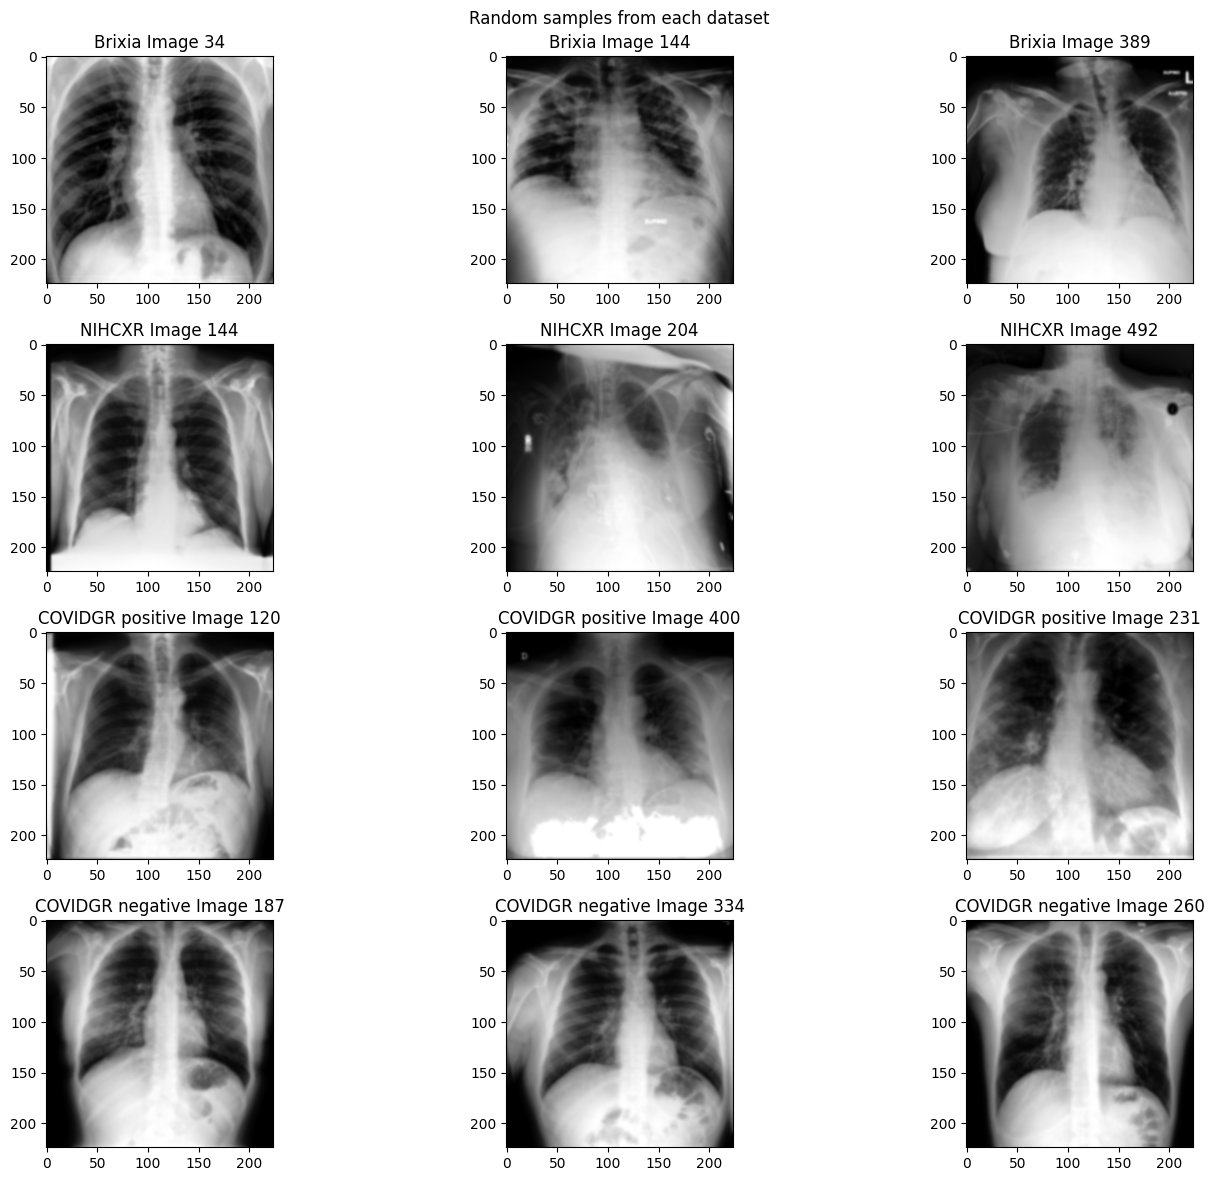

In [ ]:
# Create subplots
fig, axs = plt.subplots(4, 3, figsize=(15, 12))

# Plot random samples from each dataset
datasets = [df_brixia_np, df_nihcxr_np, df_covidgr_pos_np, df_covidgr_neg_np]
dataset_index = 0
dataset_names = ['Brixia', 'NIHCXR', 'COVIDGR positive', 'COVIDGR negative']

for row in range(4):
    for col in range(3):
        index = np.random.randint(0, len(datasets[dataset_index]))
        axs[row, col].imshow(datasets[dataset_index][index, :, :, 0], cmap='gray')
        axs[row, col].set_title(f'{dataset_names[dataset_index]} Image {index+1}')
    dataset_index += 1

# Adjust layout to prevent overlap
plt.suptitle("Random samples from each dataset")
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
for dataset, dataset_name in zip(datasets, dataset_names):
    # Calculate descriptive statistics for the current dataset
    avg_intensity = np.mean(np.mean(dataset, axis=(1, 2, 3)))
    max_intensity = np.max(np.mean(dataset, axis=(1, 2, 3)))
    min_intensity = np.min(np.mean(dataset, axis=(1, 2, 3)))
    std_intensity = np.std(np.mean(dataset, axis=(1, 2, 3)))
    std_pixel_values = np.std(dataset)

    # Print descriptive statistics
    print(f"\nDataset: {dataset_name}")
    print("Average image intensity:", avg_intensity)
    print("Maximum image intensity:", max_intensity)
    print("Minimum image intensity:", min_intensity)
    print("Standard deviation of image intensity:", std_intensity)
    print("Standard deviation of pixel values:", std_pixel_values)


Dataset: Brixia
Average image intensity: 0.5037067
Maximum image intensity: 0.5427988
Minimum image intensity: 0.5022224
Standard deviation of image intensity: 0.0021410643
Standard deviation of pixel values: 0.2859215

Dataset: NIHCXR
Average image intensity: 0.50386727
Maximum image intensity: 0.536836
Minimum image intensity: 0.5021633
Standard deviation of image intensity: 0.0034822267
Standard deviation of pixel values: 0.28523302

Dataset: COVIDGR positive
Average image intensity: 0.50364196
Maximum image intensity: 0.57363755
Minimum image intensity: 0.50210845
Standard deviation of image intensity: 0.003745052
Standard deviation of pixel values: 0.28697038

Dataset: COVIDGR negative
Average image intensity: 0.50371665
Maximum image intensity: 0.5221614
Minimum image intensity: 0.502255
Standard deviation of image intensity: 0.0020516776
Standard deviation of pixel values: 0.2860274


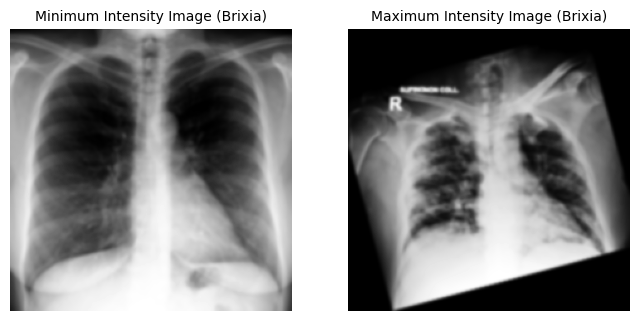

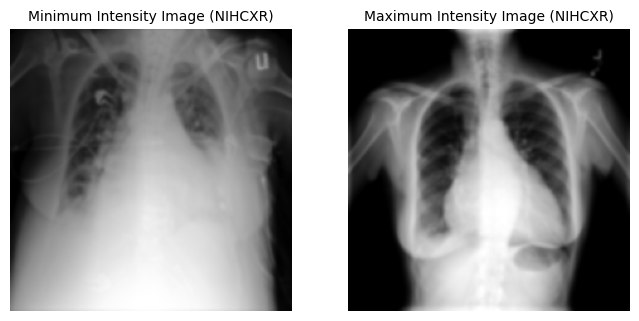

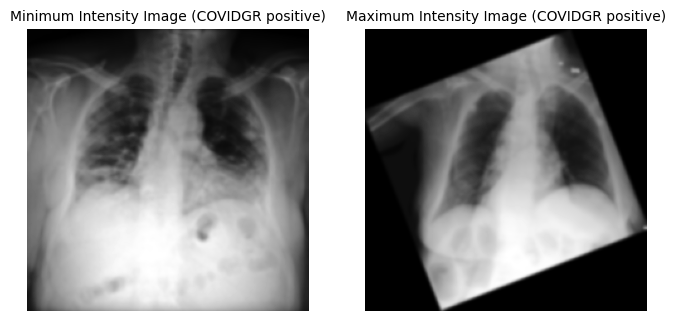

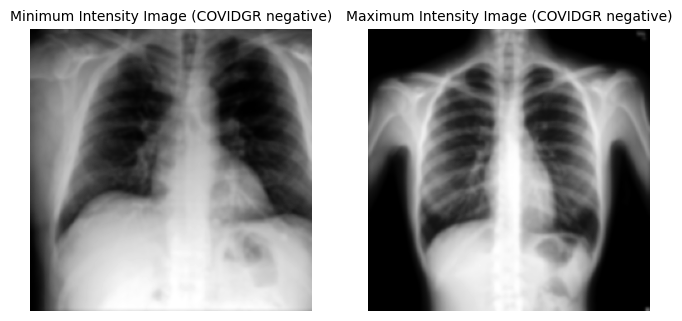

In [ ]:
for dataset, dataset_name in zip(datasets, dataset_names):
    # Find the index of the image with minimum intensity
    min_intensity_index = np.argmin(np.mean(dataset, axis=(1, 2, 3)))

    # Find the index of the image with maximum intensity
    max_intensity_index = np.argmax(np.mean(dataset, axis=(1, 2, 3)))

    # Plot the image with minimum intensity
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(dataset[min_intensity_index].squeeze(), cmap='gray')
    plt.title(f'Minimum Intensity Image ({dataset_name})', fontsize=10)
    plt.axis('off')

    # Plot the image with maximum intensity
    plt.subplot(1, 2, 2)
    plt.imshow(dataset[max_intensity_index].squeeze(), cmap='gray')
    plt.title(f'Maximum Intensity Image ({dataset_name})', fontsize=10)
    plt.axis('off')

    plt.show()

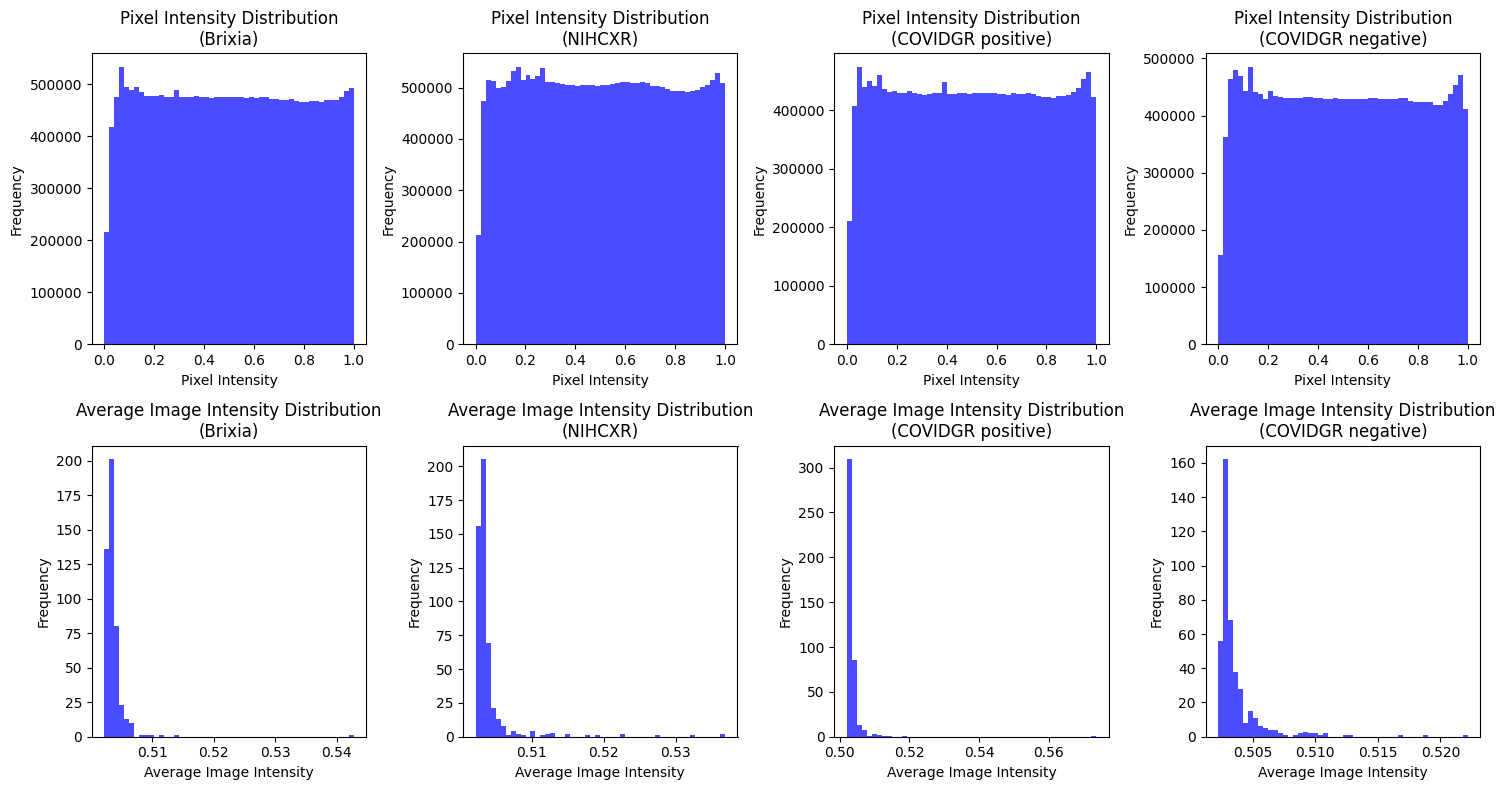

In [ ]:
# Define the number of rows and columns for subplots
num_rows = 2
num_cols = len(datasets)

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 8))

# Loop over each dataset
for col, (dataset, dataset_name) in enumerate(zip(datasets, dataset_names)):
    # Flatten the pixel values to compute histogram
    pixel_values = dataset.flatten()

    # Generate histogram for pixel intensity distribution
    axs[0, col].hist(pixel_values, bins=50, color='blue', alpha=0.7)
    axs[0, col].set_title(f'Pixel Intensity Distribution\n({dataset_name})')
    axs[0, col].set_xlabel('Pixel Intensity')
    axs[0, col].set_ylabel('Frequency')

    # Flatten the image values to compute histogram
    image_values = np.mean(dataset, axis=(1,2,3))

    # Generate histogram for average image intensity distribution
    axs[1, col].hist(image_values, bins=50, color='blue', alpha=0.7)
    axs[1, col].set_title(f'Average Image Intensity Distribution\n({dataset_name})')
    axs[1, col].set_xlabel('Average Image Intensity')
    axs[1, col].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

<a id="baseline_model"></a>
# 4. Baseline Model Selection, Justification, With Results Interpretation And Analysis

<div style="background: #f5f5dc; border: thin solid black; padding: 5px">

Considering the task at hand, a binary classification of Covid versus non-Covid on chest x-ray images with giant datasets, we decided to use transfer learning. Before the implementation of transfer learning models, we first implemented a naive CNN to see if it is able to learn anything with shallow layers, which if so then we will be able to train more data with limited GPU access. However, the naive CNN proved to be insufficient, thus we moved onto a ResNet50 model as the baseline model. For training the ResNet model, we adopted a gradient of learning rates, starting with a baseline learning rate of 1e-6 for the dense layers while freezing all the pretrained layers, then gradually decreasing the learning rate to 1e-8 and unfreezing a layer at a time to retrain the model. We started with more layers added to the ResNet structure, however we didn't have enough GPU resources to train any epoch of that model. Thus we simplified the model and tested with different hyperparameters. 


For choosing the hyperparameter, we chose the learning rates that exhibited decreasing trend for training/validation loss over epochs, and 1e-5 is the most ideal compared to 1e-4, 1e-6, and 1e-7. We also evaluated the batch size and determined that a batch size of 32 had the lowest training/validation loss, compared to a batch size of 64, 128, and 256. In addition, we evaluated different optimizers and found that Adam had the lowest training/validation loss at a learning rate of 1e-5, compared to RMSprop, SGD, Adagrad, Adadelta, and Adamax. The performance of the model was then evaluated using accuracy, loss, and AUC.  Our initial results by freezing the weights of the transfer model had a validation accuracy of 0.57 and an AUC of 0.616. After re-training the last block (3 additional convolutional + batch normalization layers) with a learning rate of 1e-6, we obtained a validation accuracy of 0.56 and an AUC of 0.528. We attemped to unfreeze the weights of another Resnet Block and re-trained it with a learning rate of 1e-8 (which performed better than lr = 1e-6, 1e-7, and 1e-9). The resulting validation accuracy is 0.57 and the AUC is 0.608. This result deviated from our expectations and our project objectives to achieve a robust model performance to classify COVID-19 cases.


 The strength of our transfer learning model is to prevent spending enormous computational resources on training a large model. Furthermore, our model architecture allows us to unfreeze and re-train additional layers with different hyperparameters if needed. However, our model performance is currently limited on the validation set, although the model was able to learn from the training image shown by a test accuracy of 0.86 after performing train_test_split on the training data. The gap between the training and validation accuracy shows a data quality gap between the training and validation images. Consequently, our next step includes including more image data in the training set, implementing other image preprocessing and dataset alignment techniques, re-training more layers of Resnet50, or try out a different model for transfer learning altogether. 

In [9]:
################################################################################
# CNN MODELS (CREATE AND COMPILE)
################################################################################
def create_model(input_shape):
    inp = Input(shape=input_shape)
    x = GaussianNoise(stddev=0.1)(inp)
    x = Conv2D(64, 2, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(64, 2, activation='relu', padding='same')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, 2, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(128, 2, activation='relu', padding='same')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(128, 2, activation='relu', padding='same')(x)
    x = Conv2D(129, 2, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(256, 2, activation='relu', padding='same')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(256, 2, activation='relu', padding='same')(x)
    x = Conv2D(256, 2, activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[inp], outputs=out)
    return model

def compile_and_train_model(model, optimizer, learning_rate, batch_size, X_train, y_train, epochs):
    es = EarlyStopping(monitor='loss', patience=5, verbose=0,
                   mode='auto',restore_best_weights=True)
    opt = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[es])
    return history

In [6]:
################################################################################
# PLOTTING HELPERS
################################################################################
def plot_helper_accuracy(model, title=None, ax=None, label_train='train', label_val='val'):
    if ax is None:
        ax = plt.gca()
    ax.plot(model.history.history['accuracy'], label='train')
    ax.plot(model.history.history['val_accuracy'], label='validation')
    best_val = np.argmax(model.history.history['val_accuracy'])
    best_val_value = np.nanmax(model.history.history['val_accuracy'])
    ax.axvline(np.argmax(model.history.history['val_accuracy']),
                    c='k', ls='--',
                    label=f'best val accuracy: {best_val_value:.2f}')
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    ax.set_title(title)
    ax.legend(loc='lower right');

def plot_helper_loss(model, title=None, ax=None, label_train='train', label_val='val'):
    if ax is None:
        ax = plt.gca()
    ax.plot(model.history.history['loss'], label=label_train)
    ax.plot(model.history.history['val_loss'], label=label_val)
    best_val = np.argmin(model.history.history['val_loss'])
    best_val_value = np.nanmin(model.history.history['val_loss'])
    ax.axvline(np.argmin(model.history.history['val_loss']),
                    c='k', ls='--',
                    label=f'best val loss: {best_val_value:.2f}')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_title(title)
    ax.legend(loc='lower right');

def plot_helper_accuracy_models(history, title=None, ax=None, label_train='train', label_val='val'):
    if ax is None:
        ax = plt.gca()
    ax.plot(history.history['accuracy'], label='train')
    ax.plot(history.history['val_accuracy'], label='validation')
    best_val = np.argmax(history.history['val_accuracy'])
    best_val_value = np.nanmax(history.history['val_accuracy'])
    ax.axvline(np.argmax(history.history['val_accuracy']),
                    c='k', ls='--',
                    label=f'best val accuracy: {best_val_value:.2f}')
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    ax.set_title(title)
    ax.legend(loc='lower right')

def plot_helper_loss_models(history, title=None, ax=None, label_train='train', label_val='val'):
    if ax is None:
        ax = plt.gca()
    ax.plot(history.history['loss'], label=label_train)
    ax.plot(history.history['val_loss'], label=label_val)
    best_val = np.argmin(history.history['val_loss'])
    best_val_value = np.nanmin(history.history['val_loss'])
    ax.axvline(np.argmin(history.history['val_loss']),
                    c='k', ls='--',
                    label=f'best val loss: {best_val_value:.2f}')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_title(title)
    ax.legend(loc='upper right')

In [10]:
################################################################################
# CNN MODELS (hyperparameter tuning: learning rate)
################################################################################
input_shape = X_train.shape[1:]

# Test learning rates
learning_rates = [0.0001, 0.001, 0.01, 0.05, 0.1] 
model_list_lr = []
history_list_lr = []
for lr in learning_rates:
    model_lr = create_model(input_shape)
    history = compile_and_train_model(model_lr, tf.keras.optimizers.Adam, lr, 32, X_train, y_train, 20)
    model_list_lr.append(model_lr)
    history_list_lr.append(history)

2024-04-24 22:02:34.494135: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 22:02:34.548038: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 22:02:34.551177: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/20


2024-04-24 22:02:37.596231: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-24 22:02:37.865003: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-04-24 22:02:38.276951: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-24 22:02:38.964357: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-24 22:02:40.729336: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc844951e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 22:02:40.729370: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capabili

25/25 [==============================] - 16s 301ms/step - loss: 0.6702 - accuracy: 0.6065 - val_loss: 0.7787 - val_accuracy: 0.0000e+00
Epoch 2/20
25/25 [==============================] - 6s 233ms/step - loss: 0.6675 - accuracy: 0.6065 - val_loss: 0.7461 - val_accuracy: 0.0000e+00
Epoch 3/20
25/25 [==============================] - 6s 233ms/step - loss: 0.6583 - accuracy: 0.6142 - val_loss: 0.7688 - val_accuracy: 0.0103
Epoch 4/20
25/25 [==============================] - 6s 234ms/step - loss: 0.6472 - accuracy: 0.6594 - val_loss: 0.7809 - val_accuracy: 0.1546
Epoch 5/20
25/25 [==============================] - 6s 234ms/step - loss: 0.6392 - accuracy: 0.6671 - val_loss: 0.6500 - val_accuracy: 0.9536
Epoch 6/20
25/25 [==============================] - 6s 234ms/step - loss: 0.6289 - accuracy: 0.6645 - val_loss: 0.7987 - val_accuracy: 0.2938
Epoch 7/20
25/25 [==============================] - 6s 235ms/step - loss: 0.5934 - accuracy: 0.7110 - val_loss: 0.7258 - val_accuracy: 0.4691
Epoch 8/

2024-04-24 22:04:45.945813: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


25/25 [==============================] - 9s 245ms/step - loss: 0.7218 - accuracy: 0.5871 - val_loss: 0.7206 - val_accuracy: 0.0000e+00
Epoch 2/20
25/25 [==============================] - 6s 228ms/step - loss: 0.6739 - accuracy: 0.6052 - val_loss: 0.9404 - val_accuracy: 0.0000e+00
Epoch 3/20
25/25 [==============================] - 6s 226ms/step - loss: 0.6748 - accuracy: 0.6052 - val_loss: 0.8963 - val_accuracy: 0.0000e+00
Epoch 4/20
25/25 [==============================] - 6s 228ms/step - loss: 0.6722 - accuracy: 0.6052 - val_loss: 0.9184 - val_accuracy: 0.0000e+00
Epoch 5/20
25/25 [==============================] - 6s 226ms/step - loss: 0.6748 - accuracy: 0.6052 - val_loss: 0.9011 - val_accuracy: 0.0000e+00
Epoch 6/20
25/25 [==============================] - 6s 226ms/step - loss: 0.6746 - accuracy: 0.6052 - val_loss: 0.8498 - val_accuracy: 0.0000e+00
Epoch 7/20
25/25 [==============================] - 6s 227ms/step - loss: 0.6753 - accuracy: 0.6052 - val_loss: 0.9064 - val_accuracy: 

2024-04-24 22:06:10.526483: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


25/25 [==============================] - 9s 232ms/step - loss: 39.3787 - accuracy: 0.5871 - val_loss: 0.9709 - val_accuracy: 0.0000e+00
Epoch 2/20
25/25 [==============================] - 5s 212ms/step - loss: 0.6760 - accuracy: 0.6052 - val_loss: 0.8227 - val_accuracy: 0.0000e+00
Epoch 3/20
25/25 [==============================] - 5s 212ms/step - loss: 0.6747 - accuracy: 0.6052 - val_loss: 0.9220 - val_accuracy: 0.0000e+00
Epoch 4/20
25/25 [==============================] - 5s 210ms/step - loss: 0.6762 - accuracy: 0.6052 - val_loss: 0.8462 - val_accuracy: 0.0000e+00
Epoch 5/20
25/25 [==============================] - 5s 212ms/step - loss: 0.6712 - accuracy: 0.6052 - val_loss: 0.9559 - val_accuracy: 0.0000e+00
Epoch 6/20
25/25 [==============================] - 5s 210ms/step - loss: 0.6787 - accuracy: 0.6052 - val_loss: 0.8701 - val_accuracy: 0.0000e+00
Epoch 7/20
25/25 [==============================] - 5s 210ms/step - loss: 0.6762 - accuracy: 0.6052 - val_loss: 0.8703 - val_accuracy:

2024-04-24 22:07:47.844416: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


25/25 [==============================] - 9s 222ms/step - loss: 1858938240.0000 - accuracy: 0.5703 - val_loss: 0.9977 - val_accuracy: 0.0000e+00
Epoch 2/20
25/25 [==============================] - 5s 207ms/step - loss: 0.6738 - accuracy: 0.6052 - val_loss: 0.7772 - val_accuracy: 0.0000e+00
Epoch 3/20
25/25 [==============================] - 5s 206ms/step - loss: 0.6749 - accuracy: 0.6052 - val_loss: 0.9754 - val_accuracy: 0.0000e+00
Epoch 4/20
25/25 [==============================] - 5s 207ms/step - loss: 0.6717 - accuracy: 0.6052 - val_loss: 0.9304 - val_accuracy: 0.0000e+00
Epoch 5/20
25/25 [==============================] - 5s 206ms/step - loss: 0.6718 - accuracy: 0.6052 - val_loss: 0.9391 - val_accuracy: 0.0000e+00
Epoch 6/20
25/25 [==============================] - 5s 206ms/step - loss: 0.6729 - accuracy: 0.6052 - val_loss: 0.9128 - val_accuracy: 0.0000e+00
Epoch 7/20
25/25 [==============================] - 5s 206ms/step - loss: 0.6728 - accuracy: 0.6052 - val_loss: 0.9449 - val_a

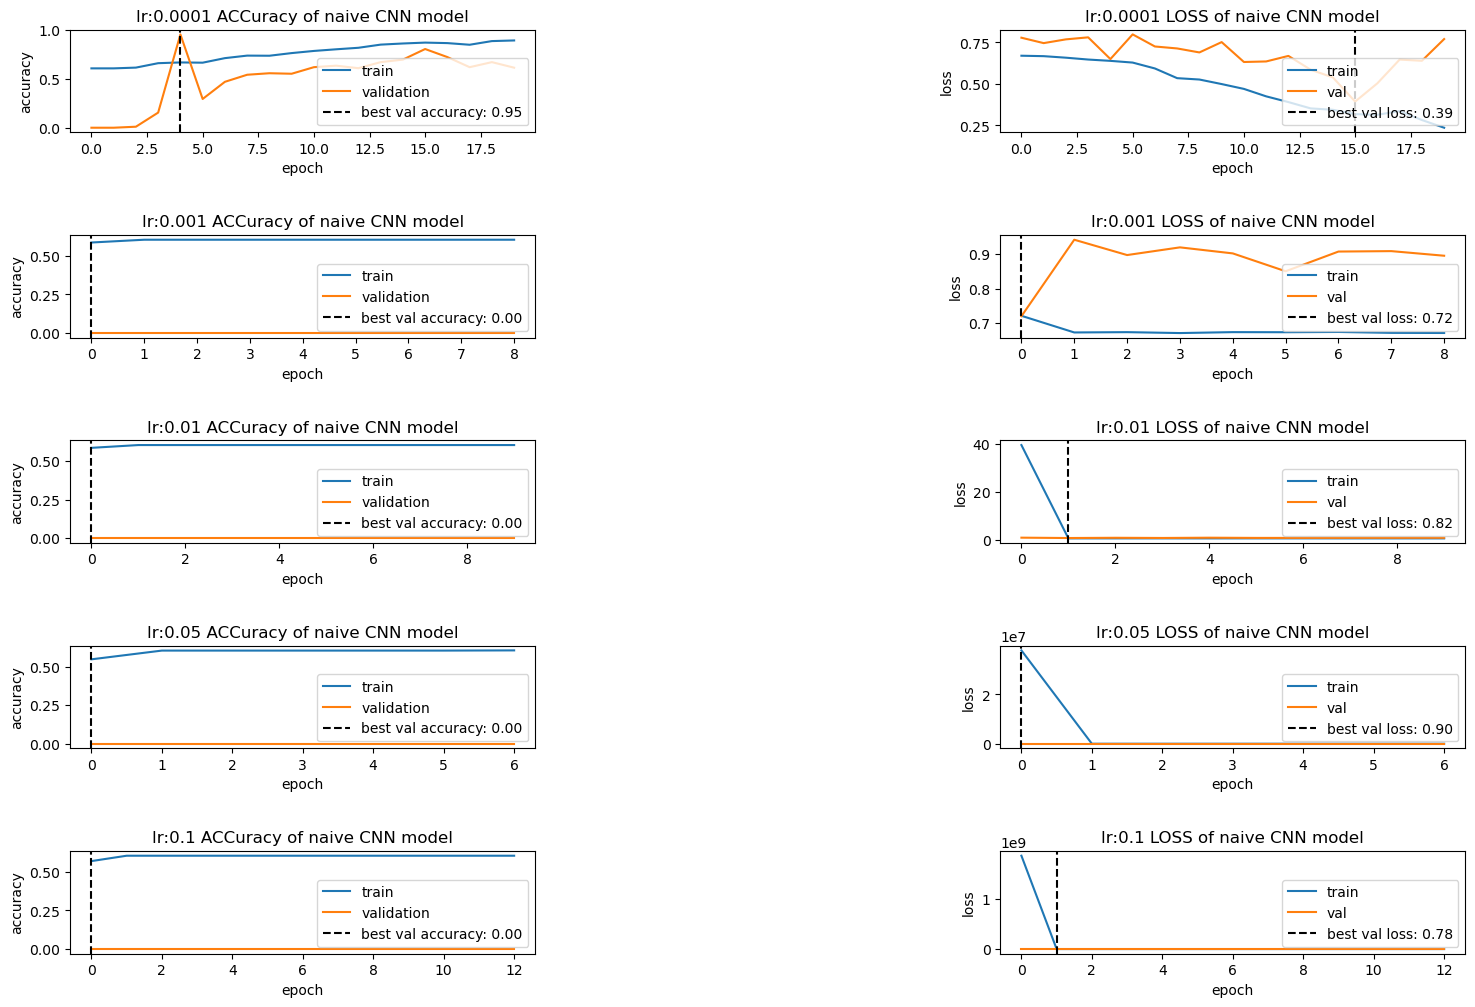

In [12]:
#Plot the results
fig, axs = plt.subplots(5, 2, figsize=(18,12))
axs = axs.flatten()
for i, modl in enumerate(model_list_lr):
    plot_helper_accuracy(modl, 
                         title=f'lr:{learning_rates[i]} ACCuracy of naive CNN model', 
                         ax=axs[i*2])
    plot_helper_loss(modl, 
                     title=f'lr:{learning_rates[i]} LOSS of naive CNN model', 
                     ax=axs[i*2+1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

In [13]:
################################################################################
# CNN MODELS (hyperparameter tuning: batch size)
################################################################################
# Test batch sizes
batch_sizes = [32, 64, 128]
model_list_batch = []
history_list_batch = []
for batch in batch_sizes:
    model_batch = create_model(input_shape)
    history = compile_and_train_model(model_batch, tf.keras.optimizers.Adam, 0.0001, batch, X_train, y_train, 10)
    model_list_batch.append(model_batch)
    history_list_batch.append(history)

Epoch 1/10


2024-04-24 22:10:23.956111: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


25/25 [==============================] - 9s 247ms/step - loss: 0.6836 - accuracy: 0.6026 - val_loss: 0.7989 - val_accuracy: 0.0000e+00
Epoch 2/10
25/25 [==============================] - 6s 233ms/step - loss: 0.6746 - accuracy: 0.6052 - val_loss: 0.7248 - val_accuracy: 0.0000e+00
Epoch 3/10
25/25 [==============================] - 6s 233ms/step - loss: 0.6704 - accuracy: 0.6052 - val_loss: 0.7985 - val_accuracy: 0.0000e+00
Epoch 4/10
25/25 [==============================] - 6s 233ms/step - loss: 0.6665 - accuracy: 0.6052 - val_loss: 0.7629 - val_accuracy: 0.0000e+00
Epoch 5/10
25/25 [==============================] - 6s 234ms/step - loss: 0.6502 - accuracy: 0.6361 - val_loss: 0.8079 - val_accuracy: 0.0052
Epoch 6/10
25/25 [==============================] - 6s 233ms/step - loss: 0.6712 - accuracy: 0.6129 - val_loss: 0.7765 - val_accuracy: 0.0000e+00
Epoch 7/10
25/25 [==============================] - 6s 233ms/step - loss: 0.6531 - accuracy: 0.6581 - val_loss: 0.7349 - val_accuracy: 0.30

2024-04-24 22:11:26.638569: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


13/13 [==============================] - 14s 468ms/step - loss: 0.6767 - accuracy: 0.5987 - val_loss: 0.7360 - val_accuracy: 0.0000e+00
Epoch 2/10
13/13 [==============================] - 6s 441ms/step - loss: 0.6696 - accuracy: 0.6052 - val_loss: 0.7483 - val_accuracy: 0.0000e+00
Epoch 3/10
13/13 [==============================] - 6s 442ms/step - loss: 0.6649 - accuracy: 0.6052 - val_loss: 0.7465 - val_accuracy: 0.0000e+00
Epoch 4/10
13/13 [==============================] - 6s 442ms/step - loss: 0.6614 - accuracy: 0.6103 - val_loss: 0.8603 - val_accuracy: 0.0000e+00
Epoch 5/10
13/13 [==============================] - 6s 440ms/step - loss: 0.6636 - accuracy: 0.6465 - val_loss: 0.7569 - val_accuracy: 0.0825
Epoch 6/10
13/13 [==============================] - 6s 443ms/step - loss: 0.6366 - accuracy: 0.6439 - val_loss: 0.7000 - val_accuracy: 0.4845
Epoch 7/10
13/13 [==============================] - 6s 443ms/step - loss: 0.6265 - accuracy: 0.6735 - val_loss: 0.6931 - val_accuracy: 0.5103


2024-04-24 22:12:32.451458: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_28/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


7/7 [==============================] - 19s 1s/step - loss: 0.6819 - accuracy: 0.5755 - val_loss: 0.7414 - val_accuracy: 0.0000e+00
Epoch 2/10
7/7 [==============================] - 6s 811ms/step - loss: 0.6760 - accuracy: 0.6052 - val_loss: 0.7370 - val_accuracy: 0.0000e+00
Epoch 3/10
7/7 [==============================] - 6s 812ms/step - loss: 0.6710 - accuracy: 0.6052 - val_loss: 0.7459 - val_accuracy: 0.0000e+00
Epoch 4/10
7/7 [==============================] - 6s 812ms/step - loss: 0.6691 - accuracy: 0.6052 - val_loss: 0.7623 - val_accuracy: 0.0000e+00
Epoch 5/10
7/7 [==============================] - 6s 805ms/step - loss: 0.6733 - accuracy: 0.6052 - val_loss: 0.7378 - val_accuracy: 0.0000e+00
Epoch 6/10
7/7 [==============================] - 6s 807ms/step - loss: 0.6734 - accuracy: 0.6052 - val_loss: 0.7512 - val_accuracy: 0.0000e+00
Epoch 7/10
7/7 [==============================] - 6s 807ms/step - loss: 0.6703 - accuracy: 0.6052 - val_loss: 0.6998 - val_accuracy: 0.0000e+00
Epoch

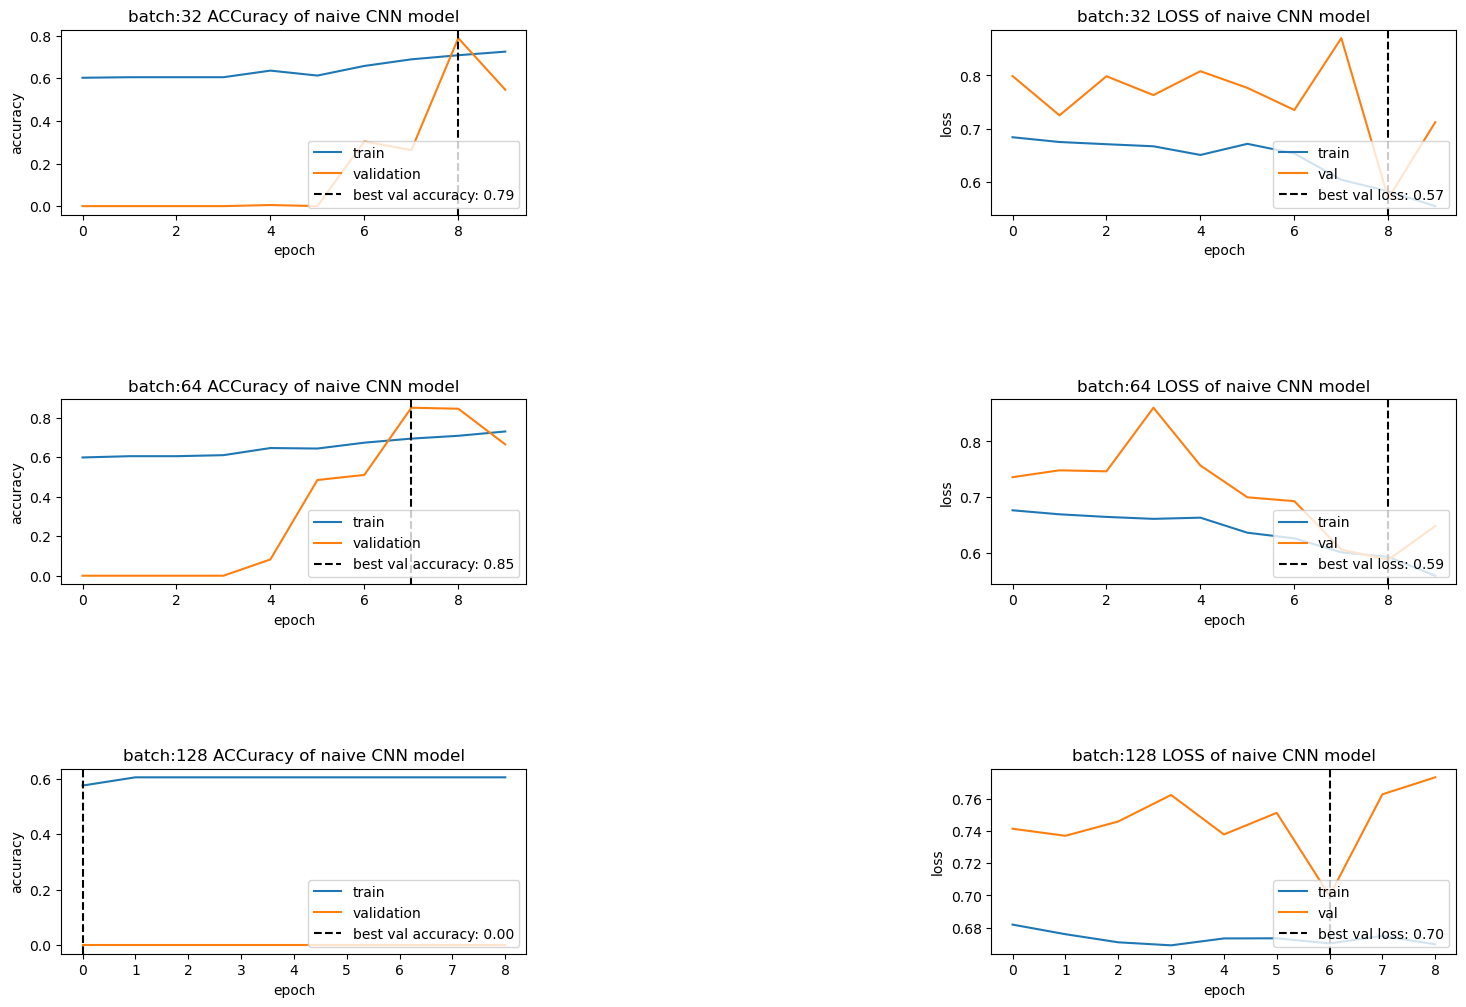

In [14]:
#Plot the results
fig, axs = plt.subplots(3, 2, figsize=(18,12))
axs = axs.flatten()
for i, modl in enumerate(model_list_batch):
    plot_helper_accuracy(modl, 
                         title=f'batch:{batch_sizes[i]} ACCuracy of naive CNN model', 
                         ax=axs[i*2])
    plot_helper_loss(modl, 
                     title=f'batch:{batch_sizes[i]} LOSS of naive CNN model', 
                     ax=axs[i*2+1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()


In [118]:
################################################################################
# PROCESs THE DATA (for transfer learning)
################################################################################
# Expand data to from 1 to 3 channels for ResNet50 model
X_train_expand = np.repeat(X_train, 3, -1)
X_test_expand = np.repeat(X_test, 3, -1)

# Split the data
# Train test split, shuffle = T 
X_train_expand_part, X_val, y_train_part, y_val = train_test_split(X_train_expand, y_train, test_size=0.2, shuffle= True, random_state=109)

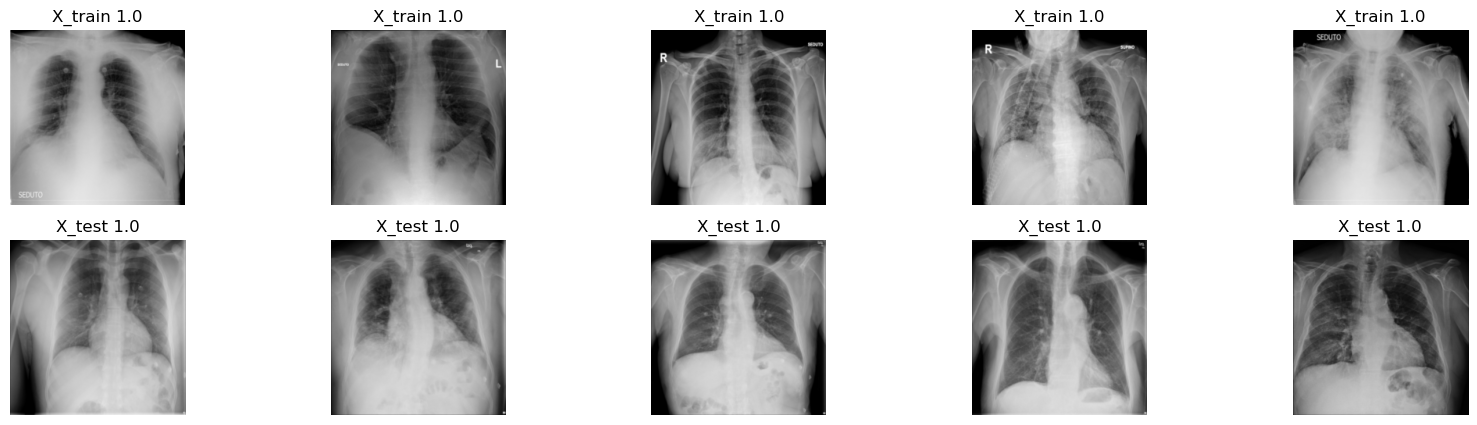

In [89]:
# Show 5 X_train and X_test expand image and its label
fig, axs = plt.subplots(2, 5, figsize=(20, 5))
for i in range(5):
    axs[0, i].imshow(X_train_expand[i])
    axs[0, i].set_title(f'X_train {y_train[i]}')
    axs[0, i].axis('off')
    axs[1, i].imshow(X_test_expand[i])
    axs[1, i].set_title(f'X_test {y_test[i]}')
    axs[1, i].axis('off')
plt.show()

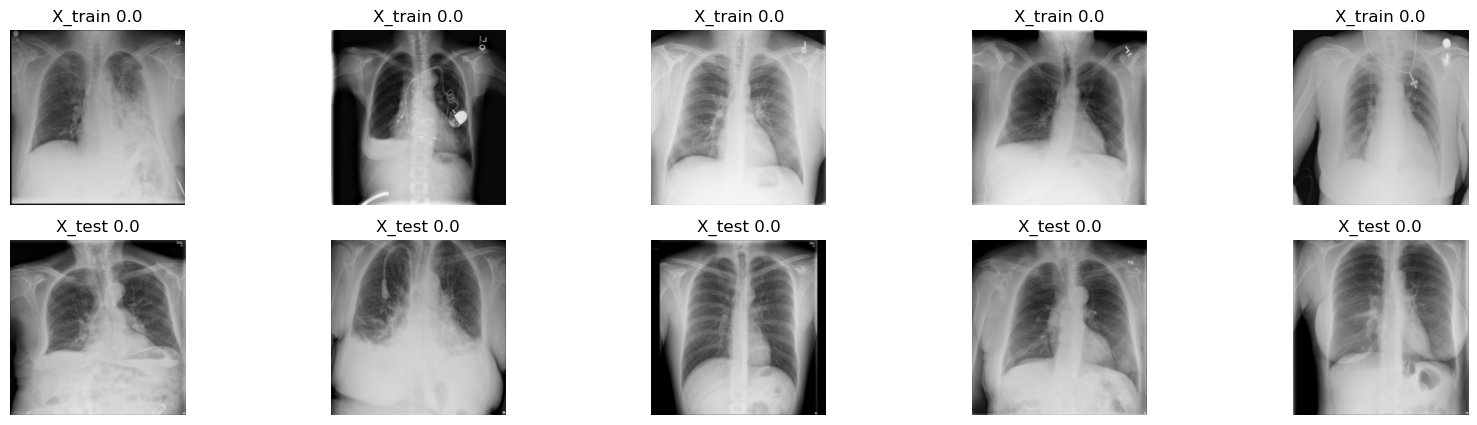

In [92]:
# Show the last 5 X_train and X_test expand image and its label
fig, axs = plt.subplots(2, 5, figsize=(20, 5))
for i in np.arange(1,6,1):
    axs[0, i-1].imshow(X_train_expand[-i])
    axs[0, i-1].set_title(f'X_train {y_train[-i]}')
    axs[0, i-1].axis('off')
    axs[1, i-1].imshow(X_test_expand[-i])
    axs[1, i-1].set_title(f'X_test {y_test[-i]}')
    axs[1, i-1].axis('off')
plt.show()

In [ ]:
################################################################################
# ResNet MODEL (CREATE AND COMPILE)
################################################################################
# Use ResNet50 for transfer learning 
def create_resnet_model(input_shape):
    # Use Imagenet weights
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in base_model.layers:
        # unfreeze the last block of ResNet50
        if layer.name in ['conv5_block3_1_conv', 'conv5_block3_1_bn', 'conv5_block3_2_conv', 'conv5_block3_2_bn', 'conv5_block3_3_conv', 'conv5_block3_3_bn']:
            layer.trainable = True
        else:
            layer.trainable = False
    # Flatten the output of ResNet50 
    x = Flatten()(base_model.output)
    # Dense + Dropout layers 
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    # Binary classification output
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=out)
    return model

# compile the transfer learning model 
def compile_and_train_resnet_model(model, optimizer, learning_rate, batch_size, X_train, y_train, X_test, y_test, epochs):
    es = EarlyStopping(monitor='loss', patience=5, verbose=0,
                   mode='auto',restore_best_weights=True)
    opt = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    # print(model.summary())
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[es])
    return history

In [143]:
################################################################################
# RUN ResNet
################################################################################
# Run the transfer learning model
resnet_model = create_resnet_model(input_shape=X_train_expand.shape[1:])
## Best learning rate = 1e-5 and batch_size = 32 from experimenting 
history_resnet = compile_and_train_resnet_model(model=resnet_model, optimizer=Adam, learning_rate=1e-5, batch_size=32, 
                                                X_train=X_train_expand_part, y_train=y_train_part, X_test=X_val, y_test=y_val, epochs=50) 

Epoch 1/50
25/25 [==============================] - 12s 181ms/step - loss: 0.6971 - accuracy: 0.5665 - val_loss: 0.7111 - val_accuracy: 0.4639
Epoch 2/50
25/25 [==============================] - 3s 120ms/step - loss: 0.5718 - accuracy: 0.6826 - val_loss: 0.7157 - val_accuracy: 0.4691
Epoch 3/50
25/25 [==============================] - 3s 119ms/step - loss: 0.5344 - accuracy: 0.7213 - val_loss: 0.7080 - val_accuracy: 0.4742
Epoch 4/50
25/25 [==============================] - 3s 120ms/step - loss: 0.4553 - accuracy: 0.7806 - val_loss: 0.7322 - val_accuracy: 0.4639
Epoch 5/50
25/25 [==============================] - 3s 115ms/step - loss: 0.4691 - accuracy: 0.7639 - val_loss: 0.7209 - val_accuracy: 0.4691
Epoch 6/50
25/25 [==============================] - 3s 119ms/step - loss: 0.4358 - accuracy: 0.7858 - val_loss: 0.7053 - val_accuracy: 0.4742
Epoch 7/50
25/25 [==============================] - 3s 115ms/step - loss: 0.4769 - accuracy: 0.7639 - val_loss: 0.6538 - val_accuracy: 0.5825
Epoch

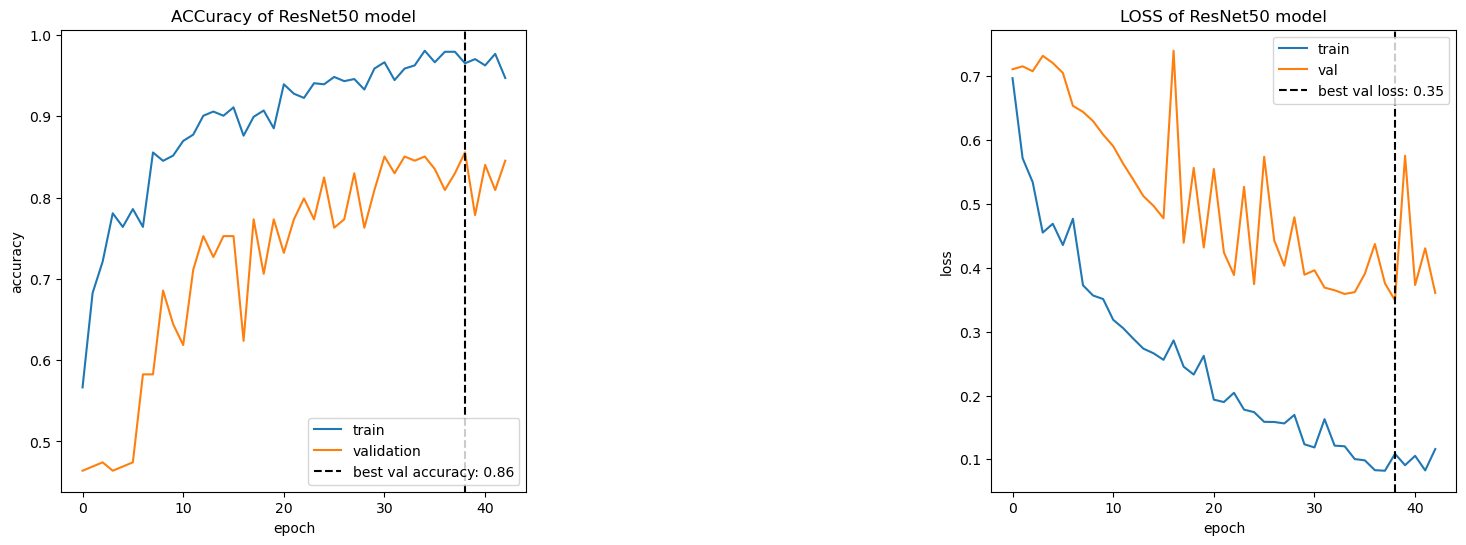

In [144]:
#Plot the results - basic ResNet
fig, axs = plt.subplots(1, 2, figsize=(18,6))
axs = axs.flatten()
plot_helper_accuracy(history_resnet, 
                         title=f'Accuracy of ResNet50 model', 
                         ax=axs[0])
plot_helper_loss(history_resnet,
                        title=f'Loss of ResNet50 model', 
                        ax=axs[1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

Epoch 1/10
25/25 [==============================] - 10s 182ms/step - loss: 1.0184 - accuracy: 0.5329 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 2/10
25/25 [==============================] - 3s 119ms/step - loss: 0.6251 - accuracy: 0.6103 - val_loss: 0.6817 - val_accuracy: 0.5412
Epoch 3/10
25/25 [==============================] - 3s 119ms/step - loss: 0.5795 - accuracy: 0.6774 - val_loss: 0.6797 - val_accuracy: 0.6649
Epoch 4/10
25/25 [==============================] - 3s 114ms/step - loss: 0.5955 - accuracy: 0.6439 - val_loss: 0.6864 - val_accuracy: 0.4948
Epoch 5/10
25/25 [==============================] - 3s 114ms/step - loss: 0.5923 - accuracy: 0.5832 - val_loss: 0.6706 - val_accuracy: 0.5361
Epoch 6/10
25/25 [==============================] - 3s 115ms/step - loss: 0.6007 - accuracy: 0.6877 - val_loss: 0.6519 - val_accuracy: 0.6340
Epoch 7/10
25/25 [==============================] - 3s 119ms/step - loss: 0.5042 - accuracy: 0.7342 - val_loss: 0.6369 - val_accuracy: 0.7010
Epoch

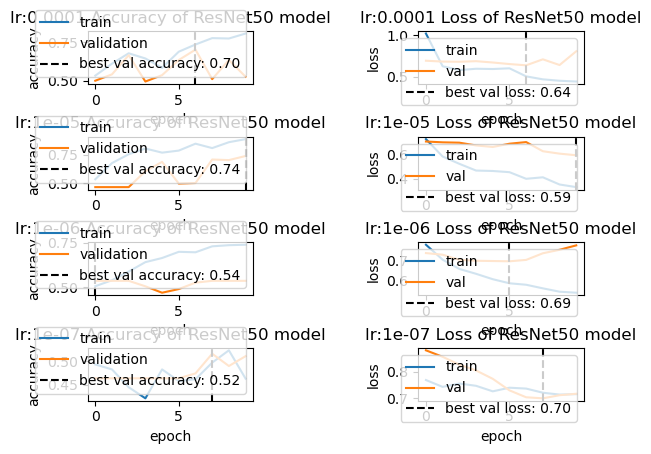

In [135]:
################################################################################
# RUN ResNet (hypeparameter tuning: learning rate)
################################################################################
# Test learning rate 
learning_rates = [1e-4, 1e-5, 1e-6, 1e-7]
model_list_lr = []
history_list_lr = []
for lr in learning_rates:
    model_lr = create_resnet_model(X_train_expand.shape[1:])
    history = compile_and_train_resnet_model(model_lr, Adam, lr, 32, X_train_expand_part, y_train_part, X_val, y_val, 10)
    model_list_lr.append(model_lr)
    history_list_lr.append(history)

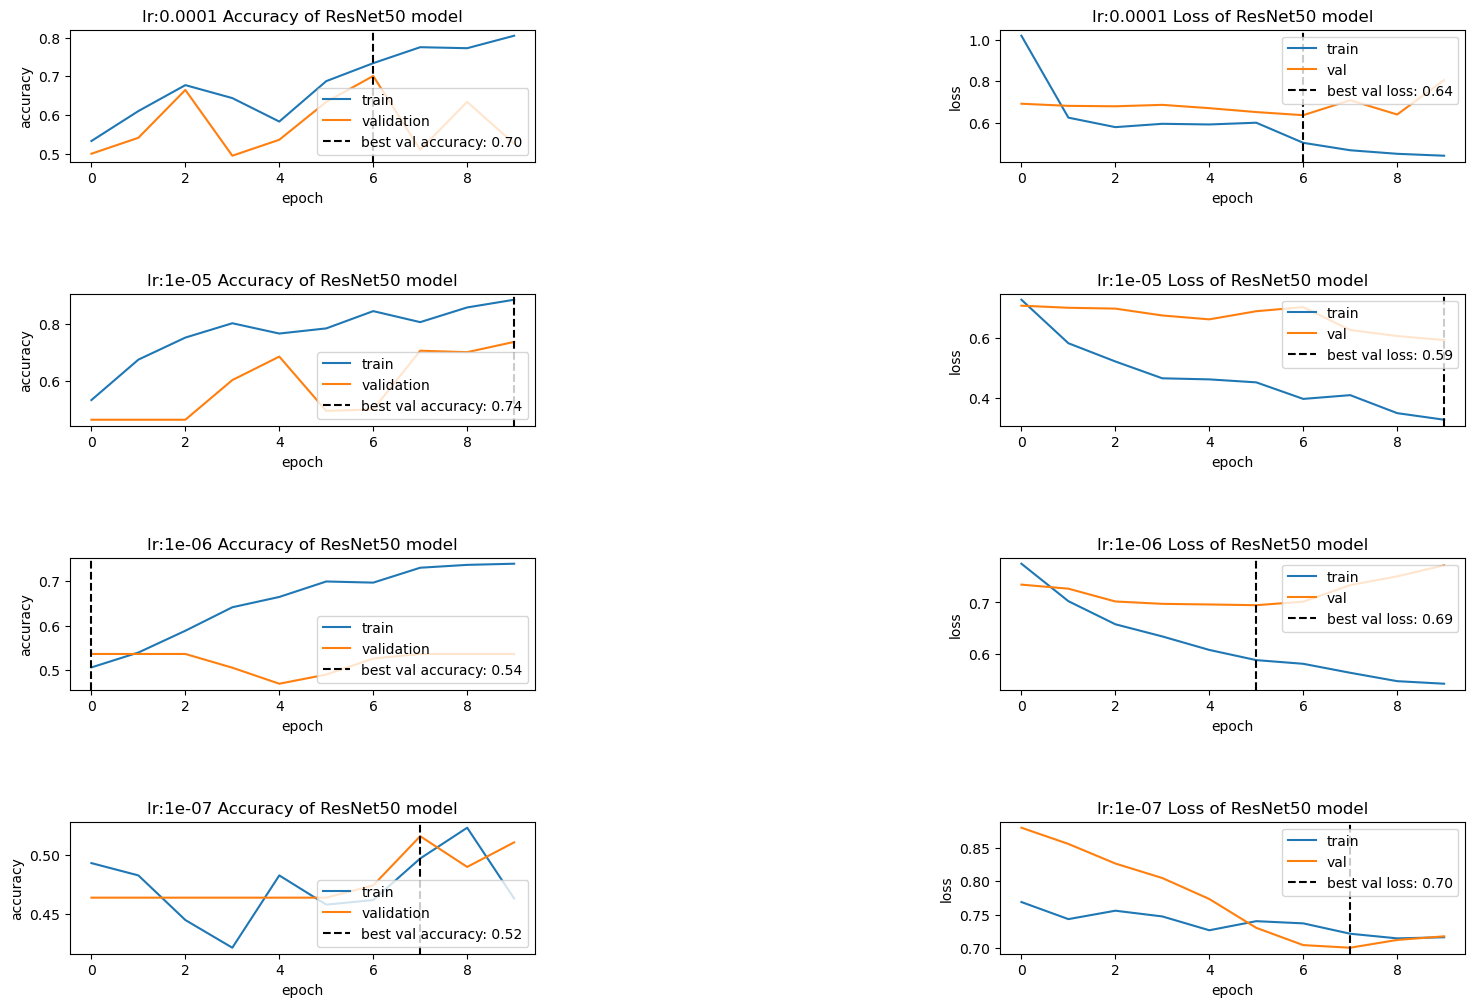

In [138]:
#plot the result - ResNet w/ learning rate
fig, axs = plt.subplots(4, 2, figsize=(18,12))
axs = axs.flatten()
for i, history in enumerate(history_list_lr):
    plot_helper_accuracy_models(history, 
                         title=f'lr:{learning_rates[i]} Accuracy of ResNet50 model', 
                         ax=axs[i*2])
    plot_helper_loss_models(history, 
                     title=f'lr:{learning_rates[i]} Loss of ResNet50 model', 
                     ax=axs[i*2+1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()


learning rate = 1e-5 shows the most consistent increased in training and validation accuracy and decrease in training and testing loss

Epoch 1/10
25/25 [==============================] - 10s 182ms/step - loss: 0.7077 - accuracy: 0.5587 - val_loss: 0.7579 - val_accuracy: 0.4639
Epoch 2/10
25/25 [==============================] - 3s 120ms/step - loss: 0.5678 - accuracy: 0.7032 - val_loss: 0.7479 - val_accuracy: 0.4639
Epoch 3/10
25/25 [==============================] - 3s 120ms/step - loss: 0.5241 - accuracy: 0.7497 - val_loss: 0.7532 - val_accuracy: 0.4639
Epoch 4/10
25/25 [==============================] - 3s 119ms/step - loss: 0.4798 - accuracy: 0.7690 - val_loss: 0.7446 - val_accuracy: 0.4639
Epoch 5/10
25/25 [==============================] - 3s 120ms/step - loss: 0.4611 - accuracy: 0.7987 - val_loss: 0.7431 - val_accuracy: 0.4639
Epoch 6/10
25/25 [==============================] - 3s 120ms/step - loss: 0.4189 - accuracy: 0.8129 - val_loss: 0.7123 - val_accuracy: 0.4691
Epoch 7/10
25/25 [==============================] - 3s 115ms/step - loss: 0.4414 - accuracy: 0.7794 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch

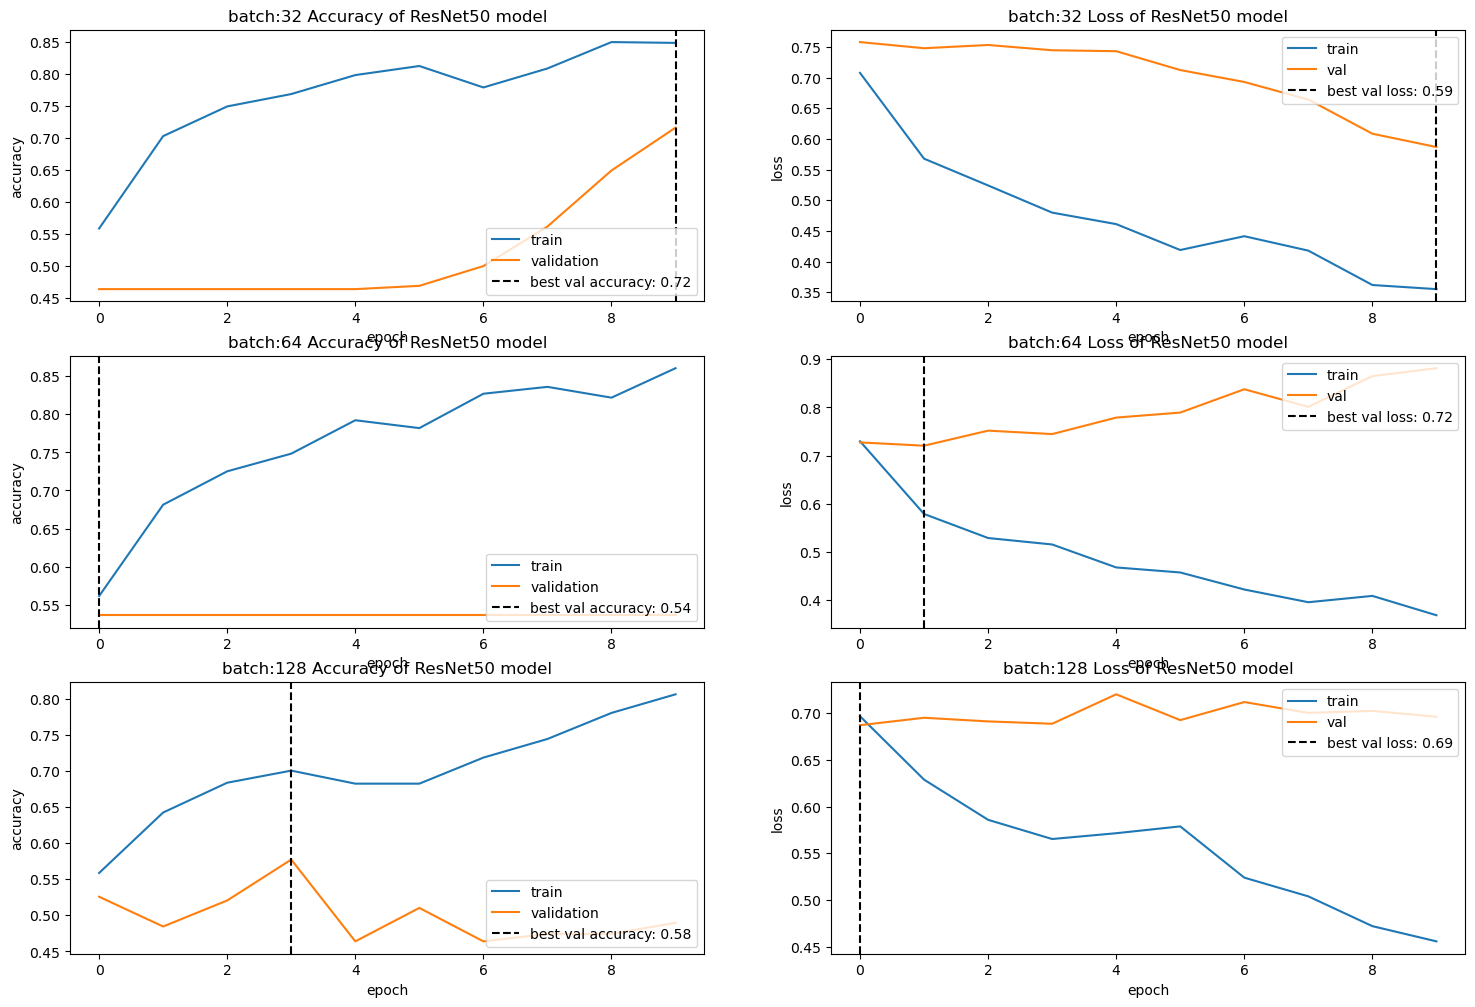

In [145]:
################################################################################
# RUN ResNet (hypeparameter tuning: batch size)
################################################################################
# Test batch size
batch_sizes = [32, 64, 128]
model_list_batch = []
history_list_batch = []
for batch in batch_sizes:
    model_batch = create_resnet_model(X_train_expand.shape[1:])
    history = compile_and_train_resnet_model(model_batch, Adam, 1e-5, batch, X_train_expand_part, y_train_part, X_val, y_val, 10) # use best learning rate
    model_list_batch.append(model_batch)
    history_list_batch.append(history)

# plot the result
fig, axs = plt.subplots(3, 2, figsize=(18,12))
axs = axs.flatten()
for i, history in enumerate(history_list_batch):
    plot_helper_accuracy_models(history, 
                         title=f'batch:{batch_sizes[i]} Accuracy of ResNet50 model', 
                         ax=axs[i*2])
    plot_helper_loss_models(history, 
                     title=f'batch:{batch_sizes[i]} Loss of ResNet50 model', 
                     ax=axs[i*2+1])

Batch size = 32 shows the most consistent increased in training and validation accuracy and decrease in training and testing loss

In [ ]:
################################################################################
# RUN ResNet (hypeparameter tuning: optimizers)
################################################################################
# Test different optimizers
optimizers = [Adam, RMSprop, SGD, Adagrad, Adadelta, Adamax]
model_list_opt = []
history_list_opt = []
for optimizer in optimizers:
    model_opt = create_resnet_model(X_train_expand.shape[1:])
    history = compile_and_train_resnet_model(model_opt, optimizer, 1e-5, 32, X_train_expand_part, y_train_part, X_val, y_val, 10)
    model_list_opt.append(model_opt)
    history_list_opt.append(history)

#plot the results
fig, axs = plt.subplots(6, 2, figsize=(18,12))
axs = axs.flatten()
for i, history in enumerate(history_list_opt):
    plot_helper_accuracy_models(history, 
                         title=f'{optimizers[i].__name__} Accuracy of ResNet50 model', 
                         ax=axs[i*2])
    plot_helper_loss_models(history, 
                     title=f'{optimizers[i].__name__} Loss of ResNet50 model', 
                     ax=axs[i*2+1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()


Adam shows the most consistent increased in training and validation accuracy and decrease in training and testing loss

In [148]:
################################################################################
# FINAL ResNet AFTER HYPERPARAMETER TUNING
## Best learning rate = 1e-5 and batch_size = 32 from experimenting 
################################################################################
# Train on whole training set and test on test set 
resnet_model = create_resnet_model(input_shape=X_train_expand.shape[1:])

history_resnet = compile_and_train_resnet_model(model=resnet_model, optimizer=Adam, learning_rate=1e-5, batch_size=32, 
                                                X_train=X_train_expand, y_train=y_train, X_test=X_test_expand, y_test=y_test, epochs=50) 

Epoch 1/50
31/31 [==============================] - 13s 241ms/step - loss: 0.6622 - accuracy: 0.6120 - val_loss: 0.8064 - val_accuracy: 0.5000
Epoch 2/50
31/31 [==============================] - 5s 171ms/step - loss: 0.5756 - accuracy: 0.6873 - val_loss: 0.8238 - val_accuracy: 0.5000
Epoch 3/50
31/31 [==============================] - 5s 172ms/step - loss: 0.4895 - accuracy: 0.7575 - val_loss: 0.7979 - val_accuracy: 0.5000
Epoch 4/50
31/31 [==============================] - 5s 172ms/step - loss: 0.4651 - accuracy: 0.7843 - val_loss: 0.7602 - val_accuracy: 0.5000
Epoch 5/50
31/31 [==============================] - 5s 172ms/step - loss: 0.4286 - accuracy: 0.7988 - val_loss: 0.7278 - val_accuracy: 0.4977
Epoch 6/50
31/31 [==============================] - 5s 172ms/step - loss: 0.4208 - accuracy: 0.8194 - val_loss: 0.7324 - val_accuracy: 0.4965
Epoch 7/50
31/31 [==============================] - 5s 173ms/step - loss: 0.4071 - accuracy: 0.8122 - val_loss: 0.7615 - val_accuracy: 0.4965
Epoch

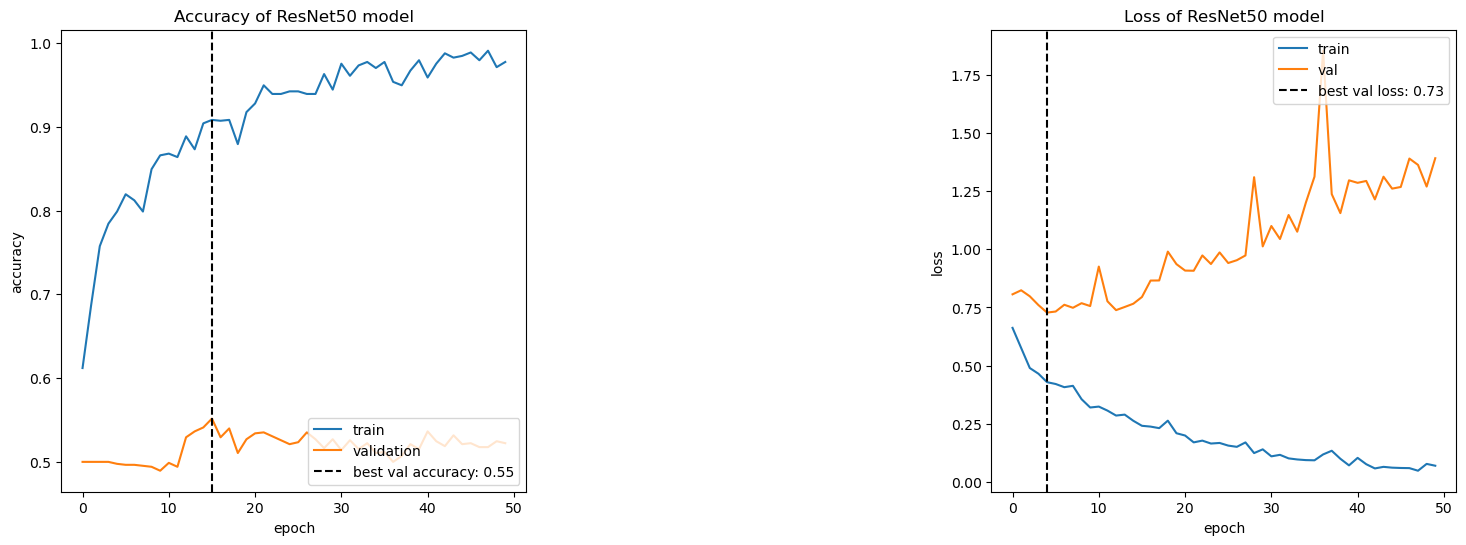

In [149]:
#plot the results
fig, axs = plt.subplots(1, 2, figsize=(18,6))
axs = axs.flatten()
plot_helper_accuracy(resnet_model, 
                         title=f'Accuracy of ResNet50 model', 
                         ax=axs[0])
plot_helper_loss(resnet_model,
                        title=f'Loss of ResNet50 model', 
                        ax=axs[1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

In [11]:
################################################################################
# Re-train the last and the second last Resnet block (3 additional convolutional + batch normalization layers) with different learning rates (1e-6 to 1e-8)
# This first section shows the model performance before unfreezing the other layers 
################################################################################

# Create ResNet model with specified input shape and initial trainable layers
# rate_adjusted_model = create_resnet_model(input_shape=(224, 224, 3), layers=[None])

rate_adjusted_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

rate_adjusted_model.trainable = False

# Flatten the output of ResNet50 
x = Flatten()(rate_adjusted_model.output)
# Dense + Dropout layers
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
# Binary classification output
out = Dense(1, activation='sigmoid')(x)
rate_adjusted_model = Model(inputs=rate_adjusted_model.input, outputs=out)

# Compile the model 
rate_adjusted_model.compile(optimizer=Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

# train the model 
es = EarlyStopping(monitor='loss', patience=5, verbose=0,
                   mode='auto',restore_best_weights=True)
history = rate_adjusted_model.fit(X_train_expand, y_train, batch_size=32, epochs=20, validation_data=(X_test_expand, y_test), callbacks=[es], verbose=1)


2024-04-24 23:00:24.028091: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 23:00:24.038079: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 23:00:24.041210: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/20


2024-04-24 23:00:32.358368: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-04-24 23:00:32.474903: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-24 23:00:34.623568: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-24 23:00:35.984457: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f95cfd705d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 23:00:35.984501: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-04-24 23:00:35.990581: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713999636.089525     542 device_compiler.h:186] Compiled

31/31 [==============================] - 19s 360ms/step - loss: 0.7763 - accuracy: 0.5335 - val_loss: 0.6912 - val_accuracy: 0.5000
Epoch 2/20
31/31 [==============================] - 6s 193ms/step - loss: 0.7110 - accuracy: 0.5263 - val_loss: 0.6912 - val_accuracy: 0.5012
Epoch 3/20
31/31 [==============================] - 6s 192ms/step - loss: 0.7101 - accuracy: 0.5222 - val_loss: 0.6879 - val_accuracy: 0.5610
Epoch 4/20
31/31 [==============================] - 6s 194ms/step - loss: 0.7083 - accuracy: 0.5377 - val_loss: 0.6867 - val_accuracy: 0.5599
Epoch 5/20
31/31 [==============================] - 6s 182ms/step - loss: 0.7110 - accuracy: 0.5449 - val_loss: 0.6924 - val_accuracy: 0.5012
Epoch 6/20
31/31 [==============================] - 6s 194ms/step - loss: 0.7007 - accuracy: 0.5470 - val_loss: 0.6884 - val_accuracy: 0.5000
Epoch 7/20
31/31 [==============================] - 6s 184ms/step - loss: 0.7031 - accuracy: 0.5408 - val_loss: 0.6853 - val_accuracy: 0.5258
Epoch 8/20
31/31

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


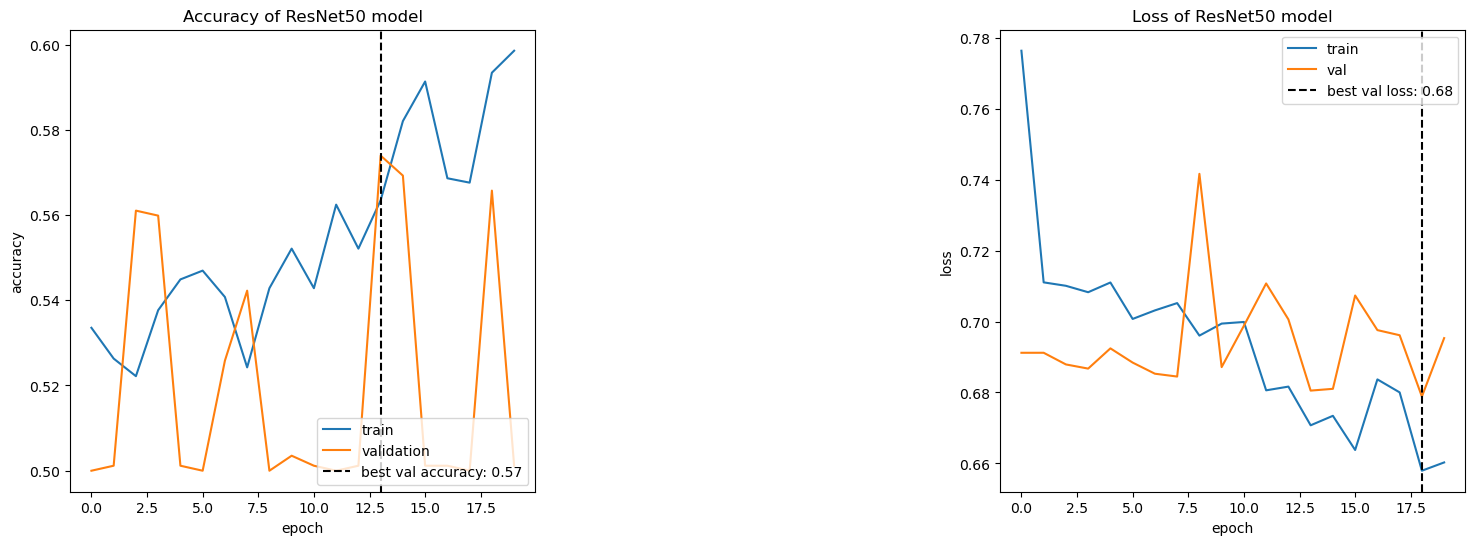

In [12]:
# Save model?
rate_adjusted_model.save('resnet_xray.h5')

# Plot loss and accuracy 
fig, axs = plt.subplots(1, 2, figsize=(18,6))
axs = axs.flatten()
plot_helper_accuracy_resnet(history, 
                         title=f'Accuracy of ResNet50 model', 
                         ax=axs[0])
plot_helper_loss_resnet(history,
                        title=f'Loss of ResNet50 model', 
                        ax=axs[1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

In [13]:
from sklearn import metrics

y_pred = rate_adjusted_model.predict(X_test_expand)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)
print('AUC: ', auc) 


27/27 [==============================] - 4s 85ms/step
AUC:  0.6161641208754877


In [17]:
################################################################################
# Retrain the last Resnet blocks 
################################################################################

# from tensorflow.keras.models import load_model
# rate_adjusted_model = load_model('resnet_xray.h5')


# Define lists of layers for different blocks
last_block_layers = ['conv5_block3_1_conv', 'conv5_block3_1_bn', 'conv5_block3_2_conv', 'conv5_block3_2_bn', 'conv5_block3_3_conv', 'conv5_block3_3_bn']

# Unfreeze last block of ResNet layers and set learning rate
for layer in rate_adjusted_model.layers:
    if layer.name in last_block_layers:
        layer.trainable = True
    # else:
    #     layer.trainable = False

# Compile model with initial learning rate for last block
rate_adjusted_model.compile(optimizer=Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

# train the model 
es = EarlyStopping(monitor='loss', patience=5, verbose=0,
                   mode='auto',restore_best_weights=True)
history = rate_adjusted_model.fit(X_train_expand, y_train, batch_size=32, epochs=20, validation_data=(X_test_expand, y_test), callbacks=[es], verbose=1)


Epoch 1/20
31/31 [==============================] - 15s 287ms/step - loss: 0.6679 - accuracy: 0.5986 - val_loss: 0.6932 - val_accuracy: 0.5023
Epoch 2/20
31/31 [==============================] - 6s 205ms/step - loss: 0.6032 - accuracy: 0.6502 - val_loss: 0.7173 - val_accuracy: 0.5012
Epoch 3/20
31/31 [==============================] - 6s 206ms/step - loss: 0.5654 - accuracy: 0.6914 - val_loss: 0.7562 - val_accuracy: 0.5000
Epoch 4/20
31/31 [==============================] - 6s 205ms/step - loss: 0.5499 - accuracy: 0.7079 - val_loss: 0.8382 - val_accuracy: 0.5000
Epoch 5/20
31/31 [==============================] - 6s 206ms/step - loss: 0.5223 - accuracy: 0.7358 - val_loss: 0.7099 - val_accuracy: 0.4988
Epoch 6/20
31/31 [==============================] - 6s 205ms/step - loss: 0.5149 - accuracy: 0.7337 - val_loss: 0.7331 - val_accuracy: 0.5000
Epoch 7/20
31/31 [==============================] - 6s 207ms/step - loss: 0.4908 - accuracy: 0.7410 - val_loss: 0.6884 - val_accuracy: 0.5258
Epoch

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


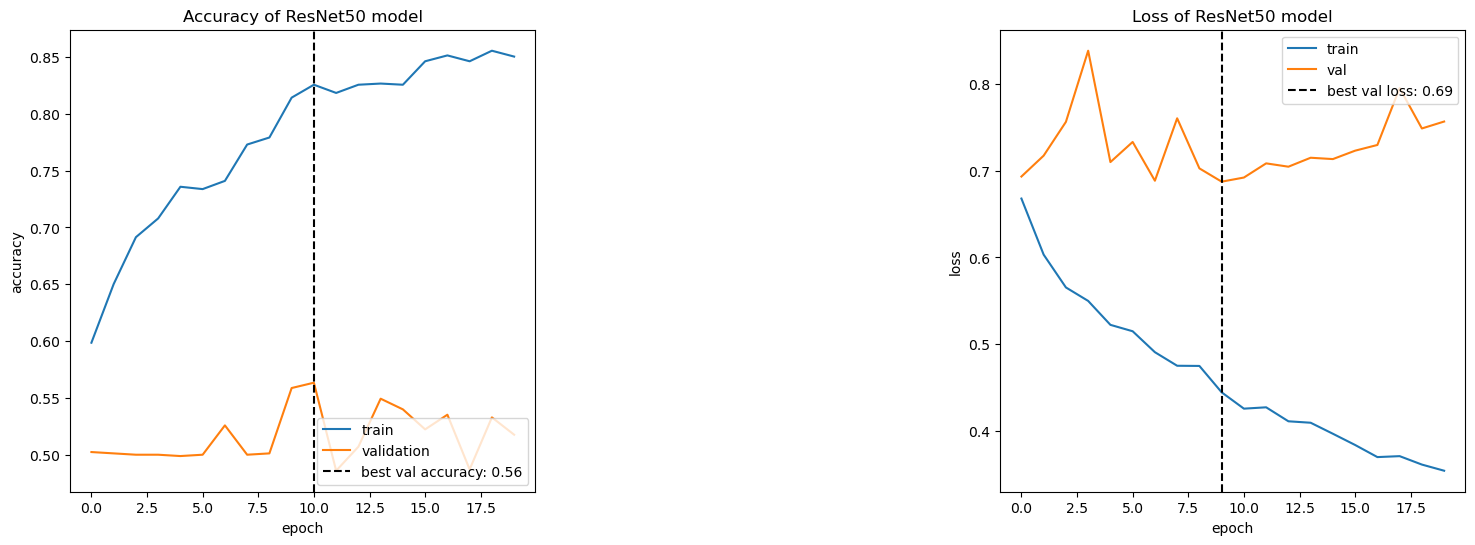

In [18]:
# Save model?
# rate_adjusted_model.save('resnet_xray.h5')

# Plot loss and accuracy 
fig, axs = plt.subplots(1, 2, figsize=(18,6))
axs = axs.flatten()
plot_helper_accuracy_resnet(history, 
                         title=f'Accuracy of ResNet50 model', 
                         ax=axs[0])
plot_helper_loss_resnet(history,
                        title=f'Loss of ResNet50 model', 
                        ax=axs[1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

In [19]:
y_pred = rate_adjusted_model.predict(X_test_expand)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)
print('AUC: ', auc) 

27/27 [==============================] - 3s 86ms/step
AUC:  0.5284280014988207


In [12]:
################################################################################
# Retrain the last two Resnet blocks with lower learing rate (lr = 1e-8)
################################################################################

# # load the model
# from tensorflow.keras.models import load_model
# rate_adjusted_model = load_model('resnet_xray.h5')

second_last_block_layers = ['conv5_block2_1_conv', 'conv5_block2_1_bn', 'conv5_block2_2_conv', 'conv5_block2_2_bn', 'conv5_block2_3_conv', 'conv5_block2_3_bn']
# Fine-tune second to last block of ResNet layers with slower learning rate 
for layer in rate_adjusted_model.layers:
    if layer.name in second_last_block_layers:
        layer.trainable = True
    # else:
    #     layer.trainable = False

# Compile model with slower learning rate for second to last block
rate_adjusted_model.compile(optimizer=Adam(learning_rate=1e-8), loss='binary_crossentropy', metrics=['accuracy'])

# train the model 
es = EarlyStopping(monitor='loss', patience=5, verbose=0,
                   mode='auto',restore_best_weights=True)
history = rate_adjusted_model.fit(X_train_expand, y_train, batch_size=32, epochs=50, validation_data=(X_test_expand, y_test), callbacks=[es], verbose=1)

2024-04-24 23:19:15.507267: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 23:19:15.516678: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 23:19:15.519739: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/50


2024-04-24 23:19:32.922184: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-04-24 23:19:33.036430: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-24 23:19:35.006541: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-24 23:19:36.522362: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1beb858f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 23:19:36.522400: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-04-24 23:19:36.528271: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714000776.626841     528 device_compiler.h:186] Compiled

31/31 [==============================] - 24s 388ms/step - loss: 0.7243 - accuracy: 0.5490 - val_loss: 0.6826 - val_accuracy: 0.5716
Epoch 2/50
31/31 [==============================] - 7s 215ms/step - loss: 0.7085 - accuracy: 0.5614 - val_loss: 0.6879 - val_accuracy: 0.5387
Epoch 3/50
31/31 [==============================] - 7s 215ms/step - loss: 0.6809 - accuracy: 0.5944 - val_loss: 0.7013 - val_accuracy: 0.5000
Epoch 4/50
31/31 [==============================] - 6s 204ms/step - loss: 0.6812 - accuracy: 0.5820 - val_loss: 0.7267 - val_accuracy: 0.5000
Epoch 5/50
31/31 [==============================] - 7s 215ms/step - loss: 0.6569 - accuracy: 0.6058 - val_loss: 0.7716 - val_accuracy: 0.5000
Epoch 6/50
31/31 [==============================] - 6s 205ms/step - loss: 0.6688 - accuracy: 0.5924 - val_loss: 0.8035 - val_accuracy: 0.5000
Epoch 7/50
31/31 [==============================] - 6s 205ms/step - loss: 0.6624 - accuracy: 0.6058 - val_loss: 0.8299 - val_accuracy: 0.5000
Epoch 8/50
31/31

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


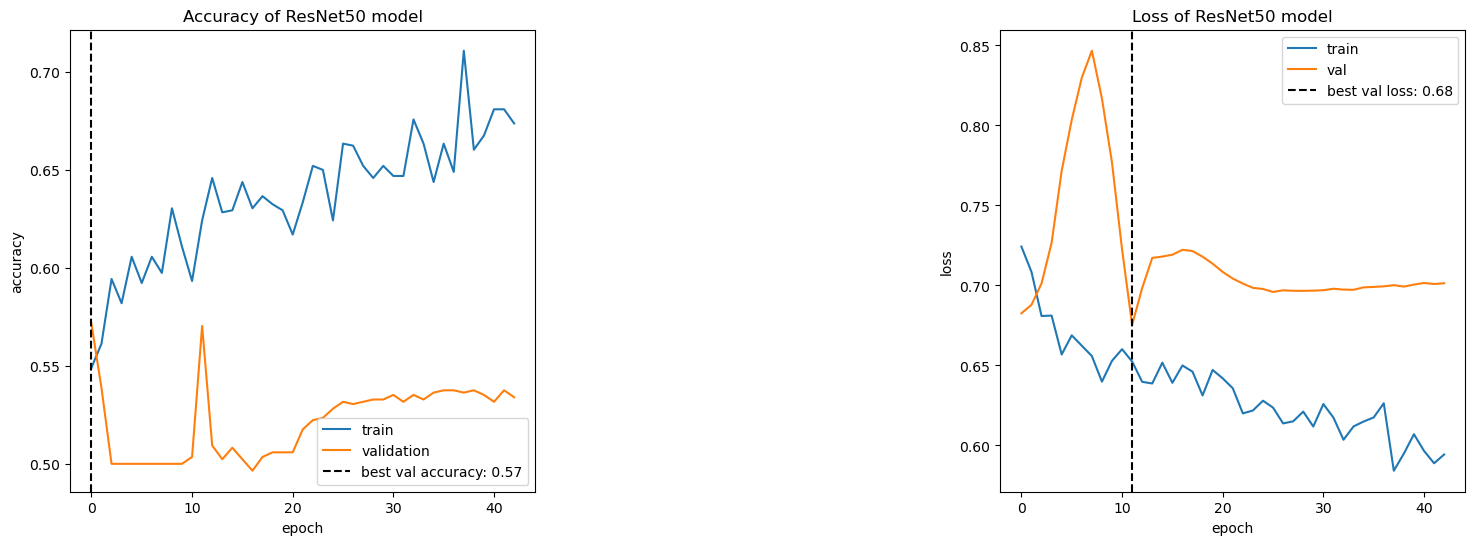

In [13]:
# Save model?
# rate_adjusted_model.save('resnet_xray.h5')

# Plot loss and accuracy 
fig, axs = plt.subplots(1, 2, figsize=(18,6))
axs = axs.flatten()
plot_helper_accuracy_resnet(history, 
                         title=f'Accuracy of ResNet50 model', 
                         ax=axs[0])
plot_helper_loss_resnet(history,
                        title=f'Loss of ResNet50 model', 
                        ax=axs[1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

In [15]:
from sklearn import metrics

y_pred = rate_adjusted_model.predict(X_test_expand)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)
print('AUC: ', auc) 


27/27 [==============================] - 2s 86ms/step
AUC:  0.6077057021314113


<a id="final_model"></a>
# 5. Final Model Pipeline Setup

<div style="background: #f5f5dc; border: thin solid black; padding: 5px">

Tentative pipeline for the next milestone's final model (from data preprocessing to evaluation)

- Decompress the 100+GB of data and turn into png/jpeg and then convert them to numpy arrays and upload them on the cloud to be able to train on the model on the full dataset. So far we have been training the models on 10% of the COVID-positive and COVID-negative train sets and validating on 100% of the validation set. 
- Balance the different datasets in terms of patient gender. Select only the images labelled with "No finding" from the NIHCXR dataset as our negative training set. 
- Preprocess the images to address distribution shifts via square cropping, resizing to 224 x 224 pixels, image intensity normalization, histogram equalization, and Gaussian filtering.
- Under the constraint of limited GPUs on jupyter hub, further fine-tune the ResNet model to improve performance. 
- Add another transfer learning model for images to test its performance against ResNet.
- Consult the teaching staff for possible GPU resources as we couldn't train much with jupyter hub and google colab.
- Evaluate the model performance with accuracy and AUROC.
- Add interpretability to understand the traits the models is learning. Specifically, using Grad-CAM to see the key pixels may help provide insights into the generalizability of the model.

- Assumptions: we assumed the transfer learning model will be able to extract the key features from the x-ray data. Additionally, we assumed that re-training the outermost layers might help with the model performance since it might learn to capture the image features. 
- Parameter choices: we compared a set of hyperparameters for learning rates, batch size, and optimizers. We first chose the learning rates and test batch sizes and optimizers on the selected learn rate. 
- Preliminary tuning considerations: we need to fine-tune the number of Resnet layers we want to re-train and adjust the learning rate for each re-trained layer.

<a id="tf_meeting"></a>
# 6. TF Meeting

<div style="background: #f5f5dc; border: thin solid black; padding: 5px">

We met with our project TF on April 19 at 1 PM. 
The discussed responsibilities and goals for each group member were as follows. 
* Adele: ⁠Image compression and data upload/download
* Kay: Address distribution shift among x-ray image datasets, look into literature for distribution shift in x-ray images
* Xinyu: Construct basic CNN and try implementing Grad-CAM for explainability
* Chuck: Implement transfer learning 